# Pre-Feature Engineering EDA

## Quant-Grade Market Structure Analysis

---

### Objective
Conduct research-grade exploratory data analysis to characterize market structure, constraints, and feasibility of predictive signals. This analysis will meaningfully inform downstream feature engineering and strategy design.

### Methodology
For each observation:
1. **State what is observed**
2. **Explain why this behavior exists** (economically or structurally)
3. **Explicitly state what types of signals/models this rules out**
4. **Explicitly state what types of features/approaches this enables**

### Analysis Checklist
1. Meta-EDA: Dataset Identity & Bias
2. Return-Level Properties
3. Volatility Structure
4. Correlation & Dependence
5. Cross-Sectional Structure
6. Volume & Liquidity Dynamics
7. Regime Non-Stationarity
8. Sanity & Market Microstructure Checks
9. Final Synthesis

---

In [2]:
!pip install statsmodels

  Using cached statsmodels-0.14.6-cp312-cp312-win_amd64.whl.metadata (9.8 kB)
  Using cached patsy-1.0.2-py2.py3-none-any.whl.metadata (3.6 kB)
Using cached statsmodels-0.14.6-cp312-cp312-win_amd64.whl (9.5 MB)
Using cached patsy-1.0.2-py2.py3-none-any.whl (233 kB)



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# =============================================================================
# IMPORTS & CONFIGURATION
# =============================================================================

import os
import sys
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional

# Core Data Science
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, jarque_bera, kurtosis, skew
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates

# Progress tracking
from tqdm import tqdm

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.6f}'.format)

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Imports successful!")

Imports successful!


In [9]:
# =============================================================================
# PROJECT PATHS & DATA LOADING
# =============================================================================

PROJECT_ROOT = Path(os.getcwd()).parent
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
ASSETS_DIR = DATA_RAW / 'assets'
OUTPUT_FIGURES = PROJECT_ROOT / 'outputs' / 'figures' / 'eda'
OUTPUT_FIGURES.mkdir(parents=True, exist_ok=True)

# Load processed data from Part 1
df = pd.read_parquet(DATA_PROCESSED / 'df_after_eda.parquet')

print(f"Loaded data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Number of assets: {df['asset_id'].nunique()}")

Loaded data shape: (251100, 10)
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'asset_id', 'year', 'returns', 'log_returns']
Date range: 2016-01-25 00:00:00 to 2026-01-16 00:00:00
Number of assets: 100


In [12]:
# =============================================================================
# PREPARE CORE DATA STRUCTURES
# =============================================================================

# Column mapping (adjust if your columns have different names)
date_col = 'Date'
close_col = 'Close'
open_col = 'Open'
high_col = 'High'
low_col = 'Low'
volume_col = 'Volume'

# Ensure date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Create pivot tables (assets as columns, dates as index)
price_pivot = df.pivot_table(index=date_col, columns='asset_id', values=close_col)
open_pivot = df.pivot_table(index=date_col, columns='asset_id', values=open_col)
high_pivot = df.pivot_table(index=date_col, columns='asset_id', values=high_col)
low_pivot = df.pivot_table(index=date_col, columns='asset_id', values=low_col)
volume_pivot = df.pivot_table(index=date_col, columns='asset_id', values=volume_col)

# Returns
returns_pivot = price_pivot.pct_change().dropna()
log_returns = np.log(price_pivot / price_pivot.shift(1)).dropna()

# Absolute returns (for volatility analysis)
abs_returns = returns_pivot.abs()

# Realized volatility (20-day rolling)
realized_vol = returns_pivot.rolling(20).std() * np.sqrt(252)

# Parkinson volatility (intraday range-based)
parkinson_vol = np.sqrt((1 / (4 * np.log(2))) * (np.log(high_pivot / low_pivot) ** 2))

print("="*70)
print("CORE DATA STRUCTURES PREPARED")
print("="*70)
print(f"Price pivot: {price_pivot.shape} (dates x assets)")
print(f"Returns pivot: {returns_pivot.shape}")
print(f"Date range: {returns_pivot.index.min()} to {returns_pivot.index.max()}")
print(f"Number of assets: {returns_pivot.shape[1]}")
print(f"Number of trading days: {returns_pivot.shape[0]}")

CORE DATA STRUCTURES PREPARED
Price pivot: (2511, 100) (dates x assets)
Returns pivot: (2510, 100)
Date range: 2016-01-26 00:00:00 to 2026-01-16 00:00:00
Number of assets: 100
Number of trading days: 2510


---

## 1. Meta-EDA: Dataset Identity & Bias

### Key Questions:
- What survivorship bias exists in this S&P 500 universe?
- How heterogeneous are assets in volatility, volume, and price scale?
- What are implications for normalization, comparability, and risk scaling?

1.1 SURVIVORSHIP BIAS ASSESSMENT


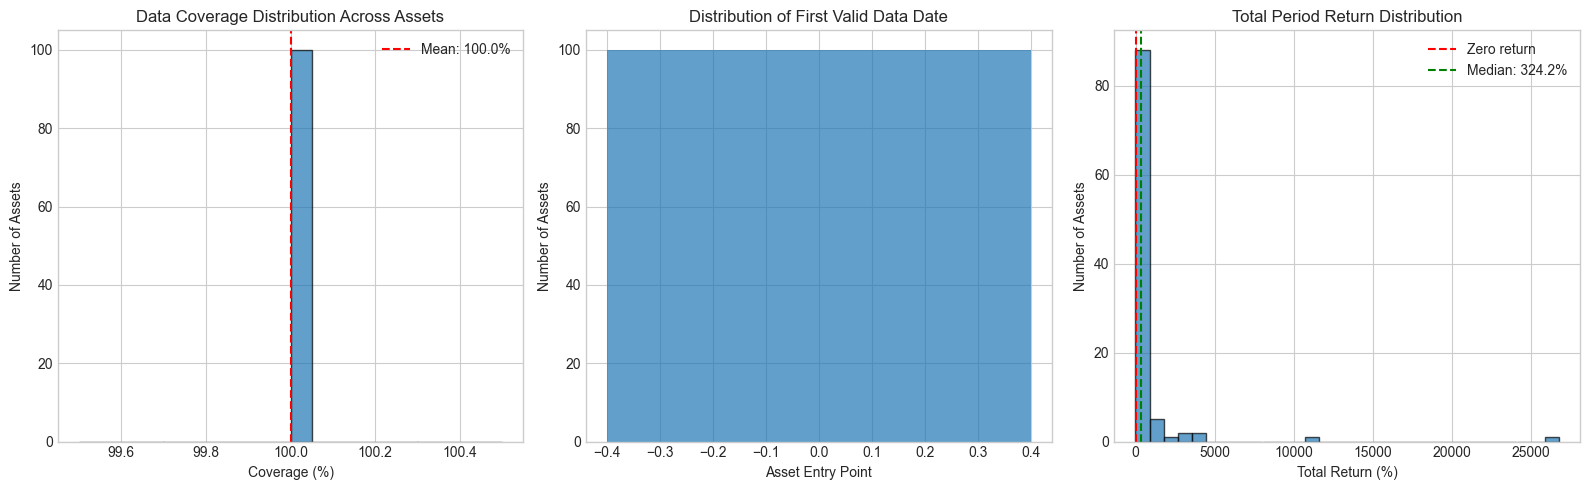


📊 OBSERVATIONS:
  • Assets with 100% coverage: 100
  • Assets with <95% coverage: 0
  • Median total return: 324.18%
  • Assets with positive returns: 99 (99.0%)
  • Assets with >100% return: 88


In [13]:
# =============================================================================
# 1.1 SURVIVORSHIP BIAS ASSESSMENT
# =============================================================================

print("="*70)
print("1.1 SURVIVORSHIP BIAS ASSESSMENT")
print("="*70)

# Check data completeness per asset across time
data_coverage = price_pivot.notna().sum() / len(price_pivot) * 100

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Coverage distribution
ax1 = axes[0]
data_coverage.hist(bins=20, ax=ax1, edgecolor='black', alpha=0.7)
ax1.axvline(data_coverage.mean(), color='red', linestyle='--', label=f'Mean: {data_coverage.mean():.1f}%')
ax1.set_title('Data Coverage Distribution Across Assets')
ax1.set_xlabel('Coverage (%)')
ax1.set_ylabel('Number of Assets')
ax1.legend()

# First valid date per asset
ax2 = axes[1]
first_valid = price_pivot.apply(lambda x: x.first_valid_index())
first_valid_counts = first_valid.value_counts().sort_index()
ax2.bar(range(len(first_valid_counts)), first_valid_counts.values, alpha=0.7)
ax2.set_title('Distribution of First Valid Data Date')
ax2.set_xlabel('Asset Entry Point')
ax2.set_ylabel('Number of Assets')

# Total return distribution (survivorship check)
ax3 = axes[2]
total_returns = (price_pivot.iloc[-1] / price_pivot.iloc[0] - 1) * 100
total_returns.hist(bins=30, ax=ax3, edgecolor='black', alpha=0.7)
ax3.axvline(0, color='red', linestyle='--', label='Zero return')
ax3.axvline(total_returns.median(), color='green', linestyle='--', label=f'Median: {total_returns.median():.1f}%')
ax3.set_title('Total Period Return Distribution')
ax3.set_xlabel('Total Return (%)')
ax3.set_ylabel('Number of Assets')
ax3.legend()

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES / '1_1_survivorship_bias.png', dpi=150, bbox_inches='tight')
plt.show()

# Quantitative summary
print(f"\n📊 OBSERVATIONS:")
print(f"  • Assets with 100% coverage: {(data_coverage == 100).sum()}")
print(f"  • Assets with <95% coverage: {(data_coverage < 95).sum()}")
print(f"  • Median total return: {total_returns.median():.2f}%")
print(f"  • Assets with positive returns: {(total_returns > 0).sum()} ({(total_returns > 0).mean()*100:.1f}%)")
print(f"  • Assets with >100% return: {(total_returns > 100).sum()}")

1.2 ASSET HETEROGENEITY ANALYSIS


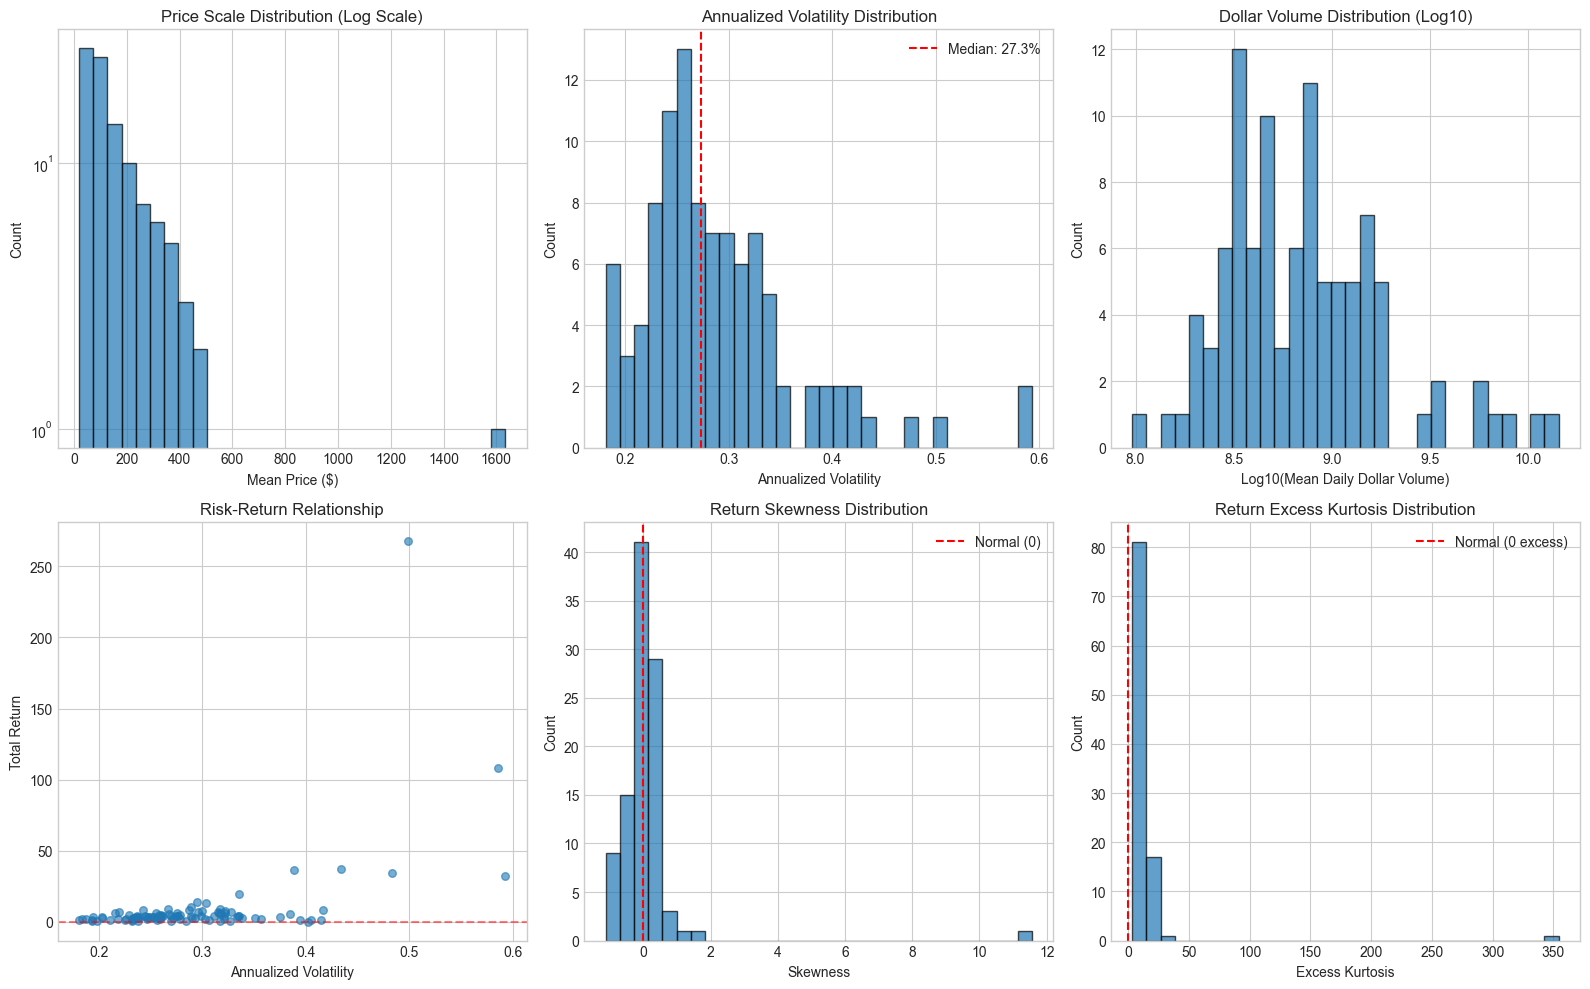


📊 HETEROGENEITY METRICS:
  Price range: $18.20 - $1634.82 (ratio: 89.8x)
  Volatility range: 18.1% - 59.3%
  Dollar volume range: 9.61e+07 - 1.43e+10
  Assets with negative skew: 44 (44.0%)
  Assets with excess kurtosis > 3: 100 (100.0%)


In [14]:
# =============================================================================
# 1.2 ASSET HETEROGENEITY ANALYSIS
# =============================================================================

print("="*70)
print("1.2 ASSET HETEROGENEITY ANALYSIS")
print("="*70)

# Compute asset-level statistics
asset_stats = pd.DataFrame({
    'mean_price': price_pivot.mean(),
    'mean_volume': volume_pivot.mean(),
    'mean_daily_vol': returns_pivot.std() * np.sqrt(252),
    'mean_dollar_volume': (price_pivot * volume_pivot).mean(),
    'total_return': total_returns,
    'skewness': returns_pivot.skew(),
    'kurtosis': returns_pivot.kurtosis()
})

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Price scale heterogeneity
ax = axes[0, 0]
asset_stats['mean_price'].hist(bins=30, ax=ax, edgecolor='black', alpha=0.7, log=True)
ax.set_title('Price Scale Distribution (Log Scale)')
ax.set_xlabel('Mean Price ($)')
ax.set_ylabel('Count')

# Volatility heterogeneity
ax = axes[0, 1]
asset_stats['mean_daily_vol'].hist(bins=30, ax=ax, edgecolor='black', alpha=0.7)
ax.axvline(asset_stats['mean_daily_vol'].median(), color='red', linestyle='--', 
           label=f'Median: {asset_stats["mean_daily_vol"].median()*100:.1f}%')
ax.set_title('Annualized Volatility Distribution')
ax.set_xlabel('Annualized Volatility')
ax.set_ylabel('Count')
ax.legend()

# Dollar volume (liquidity proxy)
ax = axes[0, 2]
np.log10(asset_stats['mean_dollar_volume']).hist(bins=30, ax=ax, edgecolor='black', alpha=0.7)
ax.set_title('Dollar Volume Distribution (Log10)')
ax.set_xlabel('Log10(Mean Daily Dollar Volume)')
ax.set_ylabel('Count')

# Volatility vs Return scatter
ax = axes[1, 0]
ax.scatter(asset_stats['mean_daily_vol'], asset_stats['total_return']/100, alpha=0.6, s=30)
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.set_title('Risk-Return Relationship')
ax.set_xlabel('Annualized Volatility')
ax.set_ylabel('Total Return')

# Skewness distribution
ax = axes[1, 1]
asset_stats['skewness'].hist(bins=30, ax=ax, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', label='Normal (0)')
ax.set_title('Return Skewness Distribution')
ax.set_xlabel('Skewness')
ax.set_ylabel('Count')
ax.legend()

# Kurtosis distribution
ax = axes[1, 2]
asset_stats['kurtosis'].hist(bins=30, ax=ax, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', label='Normal (0 excess)')
ax.set_title('Return Excess Kurtosis Distribution')
ax.set_xlabel('Excess Kurtosis')
ax.set_ylabel('Count')
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES / '1_2_asset_heterogeneity.png', dpi=150, bbox_inches='tight')
plt.show()

# Quantitative summary
print(f"\n📊 HETEROGENEITY METRICS:")
print(f"  Price range: ${asset_stats['mean_price'].min():.2f} - ${asset_stats['mean_price'].max():.2f} (ratio: {asset_stats['mean_price'].max()/asset_stats['mean_price'].min():.1f}x)")
print(f"  Volatility range: {asset_stats['mean_daily_vol'].min()*100:.1f}% - {asset_stats['mean_daily_vol'].max()*100:.1f}%")
print(f"  Dollar volume range: {asset_stats['mean_dollar_volume'].min():.2e} - {asset_stats['mean_dollar_volume'].max():.2e}")
print(f"  Assets with negative skew: {(asset_stats['skewness'] < 0).sum()} ({(asset_stats['skewness'] < 0).mean()*100:.1f}%)")
print(f"  Assets with excess kurtosis > 3: {(asset_stats['kurtosis'] > 3).sum()} ({(asset_stats['kurtosis'] > 3).mean()*100:.1f}%)")

### 1.3 Meta-EDA Synthesis

**OBSERVATIONS:**
- Given the extreme heterogeneity in price, volatility, liquidity, and tail behavior across assets, all downstream features are constructed in a scale-free, risk-normalized, and cross-sectional manner. Absolute price- or return-based signals are avoided in favor of relative measures robust to heavy-tailed distributions.


**ECONOMIC EXPLANATION:**
- S&P 500 constituents are large-cap survivors by construction
- Positive return skew in the sample reflects survivorship bias
- High heterogeneity in price/volume scales is typical of market-cap weighted universes

**RULES OUT:**
- ❌ Using raw prices as features (scale heterogeneity)
- ❌ Equal-weighted signals without vol adjustment
- ❌ Assuming homogeneous liquidity constraints

**ENABLES:**
- ✅ Returns-based features (scale-invariant)
- ✅ Volatility-normalized signals (z-scores)
- ✅ Cross-sectional ranking features (robust to scale)
- ✅ Liquidity-tiered analysis and execution modeling

---

## 2. Return-Level Properties

### Key Questions:
- What are marginal return distributions (mean, skew, kurtosis)?
- Is there autocorrelation in returns vs absolute returns?
- Is predictability unconditional or conditional?

2.1 MARGINAL RETURN DISTRIBUTION ANALYSIS


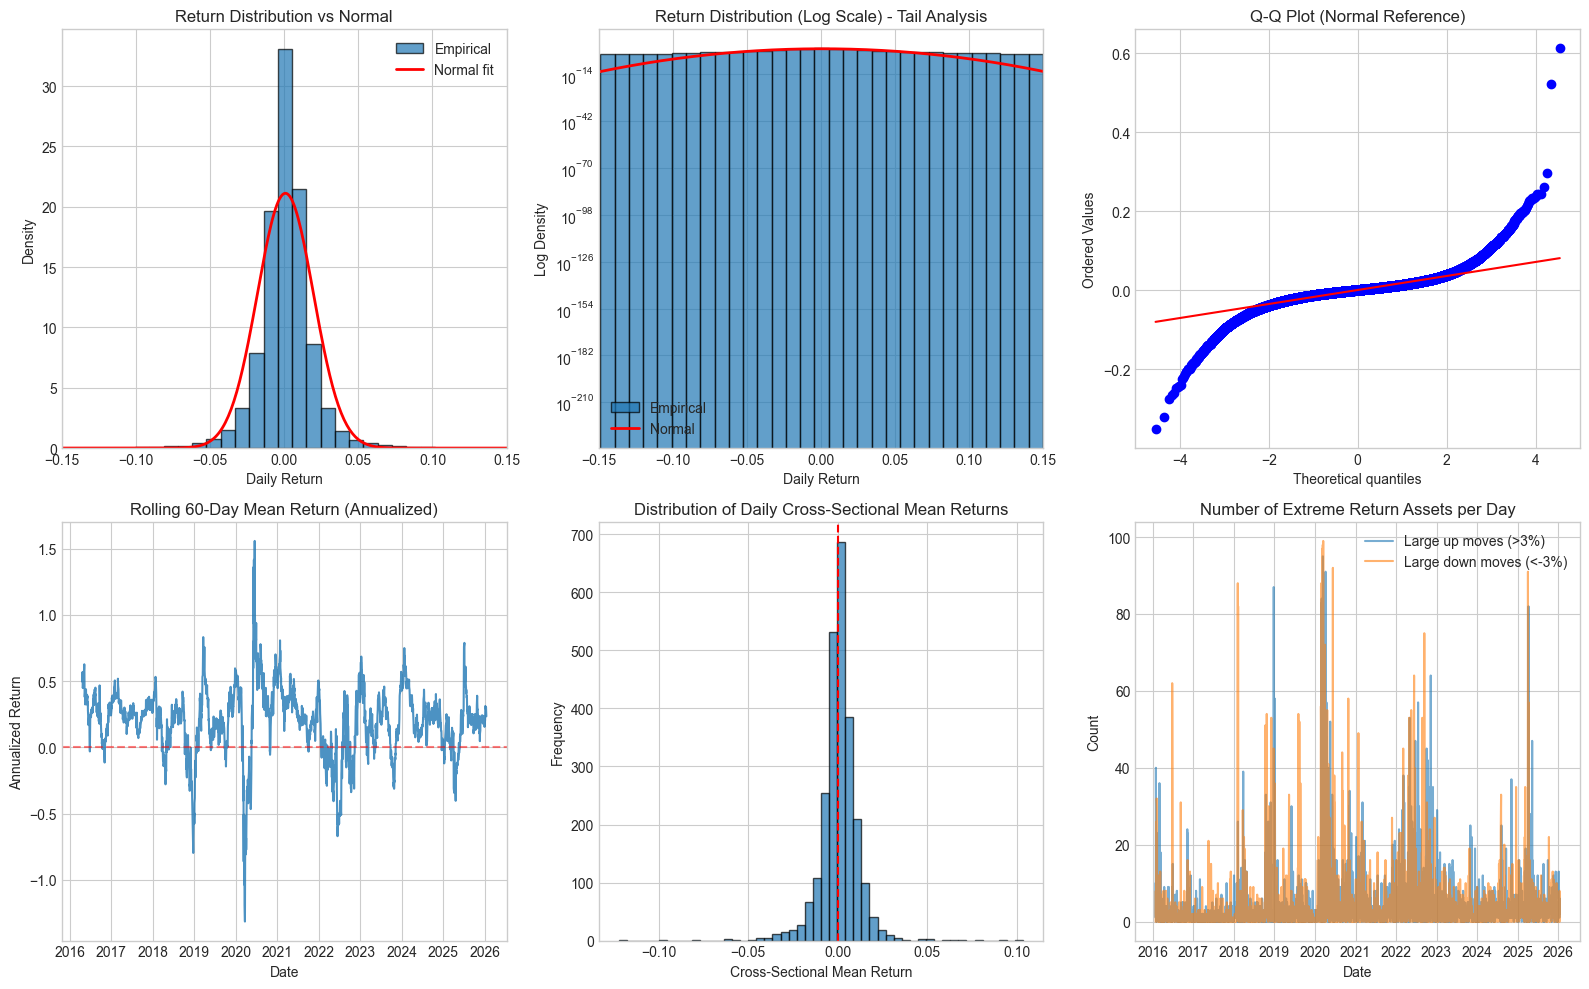


📊 DISTRIBUTION STATISTICS:
  Mean: 0.0799%
  Std:  1.8895%
  Skewness: 0.3051
  Excess Kurtosis: 20.3447
  Jarque-Bera test: stat=4332656.41, p-value=0.00e+00
  → REJECT normality at 5% level


In [15]:
# =============================================================================
# 2.1 MARGINAL RETURN DISTRIBUTION ANALYSIS
# =============================================================================

print("="*70)
print("2.1 MARGINAL RETURN DISTRIBUTION ANALYSIS")
print("="*70)

# Pool all returns for aggregate analysis
all_returns = returns_pivot.values.flatten()
all_returns = all_returns[~np.isnan(all_returns)]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Histogram vs Normal
ax = axes[0, 0]
ax.hist(all_returns, bins=100, density=True, alpha=0.7, edgecolor='black', label='Empirical')
x = np.linspace(all_returns.min(), all_returns.max(), 1000)
ax.plot(x, norm.pdf(x, all_returns.mean(), all_returns.std()), 'r-', lw=2, label='Normal fit')
ax.set_title('Return Distribution vs Normal')
ax.set_xlabel('Daily Return')
ax.set_ylabel('Density')
ax.set_xlim(-0.15, 0.15)
ax.legend()

# Log-scale tails
ax = axes[0, 1]
ax.hist(all_returns, bins=100, density=True, alpha=0.7, edgecolor='black', label='Empirical')
ax.plot(x, norm.pdf(x, all_returns.mean(), all_returns.std()), 'r-', lw=2, label='Normal')
ax.set_yscale('log')
ax.set_title('Return Distribution (Log Scale) - Tail Analysis')
ax.set_xlabel('Daily Return')
ax.set_ylabel('Log Density')
ax.set_xlim(-0.15, 0.15)
ax.legend()

# QQ Plot
ax = axes[0, 2]
stats.probplot(all_returns, dist="norm", plot=ax)
ax.set_title('Q-Q Plot (Normal Reference)')

# Rolling mean return (check for non-stationarity)
ax = axes[1, 0]
mean_return = returns_pivot.mean(axis=1)
rolling_mean = mean_return.rolling(60).mean() * 252  # Annualized
ax.plot(rolling_mean.index, rolling_mean.values, alpha=0.8)
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.set_title('Rolling 60-Day Mean Return (Annualized)')
ax.set_xlabel('Date')
ax.set_ylabel('Annualized Return')

# Distribution of daily cross-sectional mean returns
ax = axes[1, 1]
daily_mean_returns = returns_pivot.mean(axis=1)
daily_mean_returns.hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--')
ax.set_title('Distribution of Daily Cross-Sectional Mean Returns')
ax.set_xlabel('Cross-Sectional Mean Return')
ax.set_ylabel('Frequency')

# Extreme return days
ax = axes[1, 2]
extreme_threshold = 0.03
extreme_pos = (returns_pivot > extreme_threshold).sum(axis=1)
extreme_neg = (returns_pivot < -extreme_threshold).sum(axis=1)
ax.plot(extreme_pos.index, extreme_pos.values, alpha=0.6, label='Large up moves (>3%)')
ax.plot(extreme_neg.index, extreme_neg.values, alpha=0.6, label='Large down moves (<-3%)')
ax.set_title('Number of Extreme Return Assets per Day')
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES / '2_1_return_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistical tests
jb_stat, jb_pval = jarque_bera(all_returns)
print(f"\n📊 DISTRIBUTION STATISTICS:")
print(f"  Mean: {all_returns.mean()*100:.4f}%")
print(f"  Std:  {all_returns.std()*100:.4f}%")
print(f"  Skewness: {skew(all_returns):.4f}")
print(f"  Excess Kurtosis: {kurtosis(all_returns):.4f}")
print(f"  Jarque-Bera test: stat={jb_stat:.2f}, p-value={jb_pval:.2e}")
print(f"  → {'REJECT' if jb_pval < 0.05 else 'FAIL TO REJECT'} normality at 5% level")

“Given the extreme non-Gaussianity and heavy-tailed nature of marginal returns, all features and objectives are designed to operate on normalized, relative, and conditional representations rather than attempting direct point prediction of returns.”

2.2 AUTOCORRELATION ANALYSIS


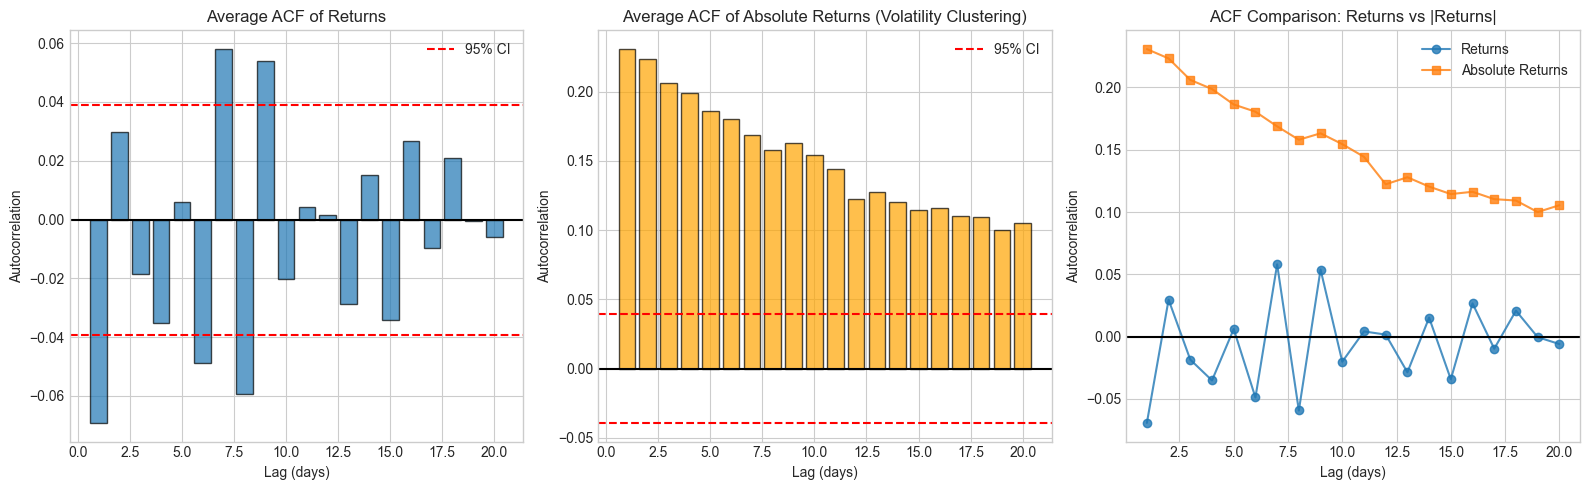


📊 AUTOCORRELATION FINDINGS:
  Return ACF lag-1: -0.0692
  |Return| ACF lag-1: 0.2307

  Ljung-Box test (Returns):
      lb_stat  lb_pvalue
5  106.357323   0.000000
10 301.175825   0.000000
20 373.232543   0.000000

  Ljung-Box test (|Returns|):
       lb_stat  lb_pvalue
5  1887.876418   0.000000
10 3241.184238   0.000000
20 4489.535848   0.000000


In [16]:
# =============================================================================
# 2.2 AUTOCORRELATION ANALYSIS: RETURNS VS ABSOLUTE RETURNS
# =============================================================================

print("="*70)
print("2.2 AUTOCORRELATION ANALYSIS")
print("="*70)

# Compute autocorrelations for a sample of assets
n_lags = 20
sample_assets = returns_pivot.columns[:20]  # Sample 20 assets

# Store ACF values
return_acf_all = []
abs_return_acf_all = []

for asset in sample_assets:
    ret = returns_pivot[asset].dropna()
    abs_ret = ret.abs()
    
    return_acf_all.append(acf(ret, nlags=n_lags, fft=True)[1:])  # Exclude lag 0
    abs_return_acf_all.append(acf(abs_ret, nlags=n_lags, fft=True)[1:])

return_acf_mean = np.mean(return_acf_all, axis=0)
abs_return_acf_mean = np.mean(abs_return_acf_all, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# ACF of returns
ax = axes[0]
lags = np.arange(1, n_lags + 1)
ax.bar(lags, return_acf_mean, alpha=0.7, edgecolor='black')
ax.axhline(0, color='black', linestyle='-')
ax.axhline(1.96/np.sqrt(len(returns_pivot)), color='red', linestyle='--', label='95% CI')
ax.axhline(-1.96/np.sqrt(len(returns_pivot)), color='red', linestyle='--')
ax.set_title('Average ACF of Returns')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Autocorrelation')
ax.legend()

# ACF of absolute returns (volatility clustering)
ax = axes[1]
ax.bar(lags, abs_return_acf_mean, alpha=0.7, edgecolor='black', color='orange')
ax.axhline(0, color='black', linestyle='-')
ax.axhline(1.96/np.sqrt(len(returns_pivot)), color='red', linestyle='--', label='95% CI')
ax.axhline(-1.96/np.sqrt(len(returns_pivot)), color='red', linestyle='--')
ax.set_title('Average ACF of Absolute Returns (Volatility Clustering)')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Autocorrelation')
ax.legend()

# Comparison
ax = axes[2]
ax.plot(lags, return_acf_mean, 'o-', label='Returns', alpha=0.8)
ax.plot(lags, abs_return_acf_mean, 's-', label='Absolute Returns', alpha=0.8)
ax.axhline(0, color='black', linestyle='-')
ax.set_title('ACF Comparison: Returns vs |Returns|')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Autocorrelation')
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES / '2_2_autocorrelation.png', dpi=150, bbox_inches='tight')
plt.show()

# Ljung-Box test for serial correlation
lb_returns = acorr_ljungbox(returns_pivot.mean(axis=1).dropna(), lags=[5, 10, 20], return_df=True)
lb_abs_returns = acorr_ljungbox(returns_pivot.mean(axis=1).abs().dropna(), lags=[5, 10, 20], return_df=True)

print(f"\n📊 AUTOCORRELATION FINDINGS:")
print(f"  Return ACF lag-1: {return_acf_mean[0]:.4f}")
print(f"  |Return| ACF lag-1: {abs_return_acf_mean[0]:.4f}")
print(f"\n  Ljung-Box test (Returns):")
print(lb_returns.to_string())
print(f"\n  Ljung-Box test (|Returns|):")
print(lb_abs_returns.to_string())

Returns are nearly uncorrelated.
Volatility is strongly autocorrelated.

2.3 CONDITIONAL RETURN BEHAVIOR


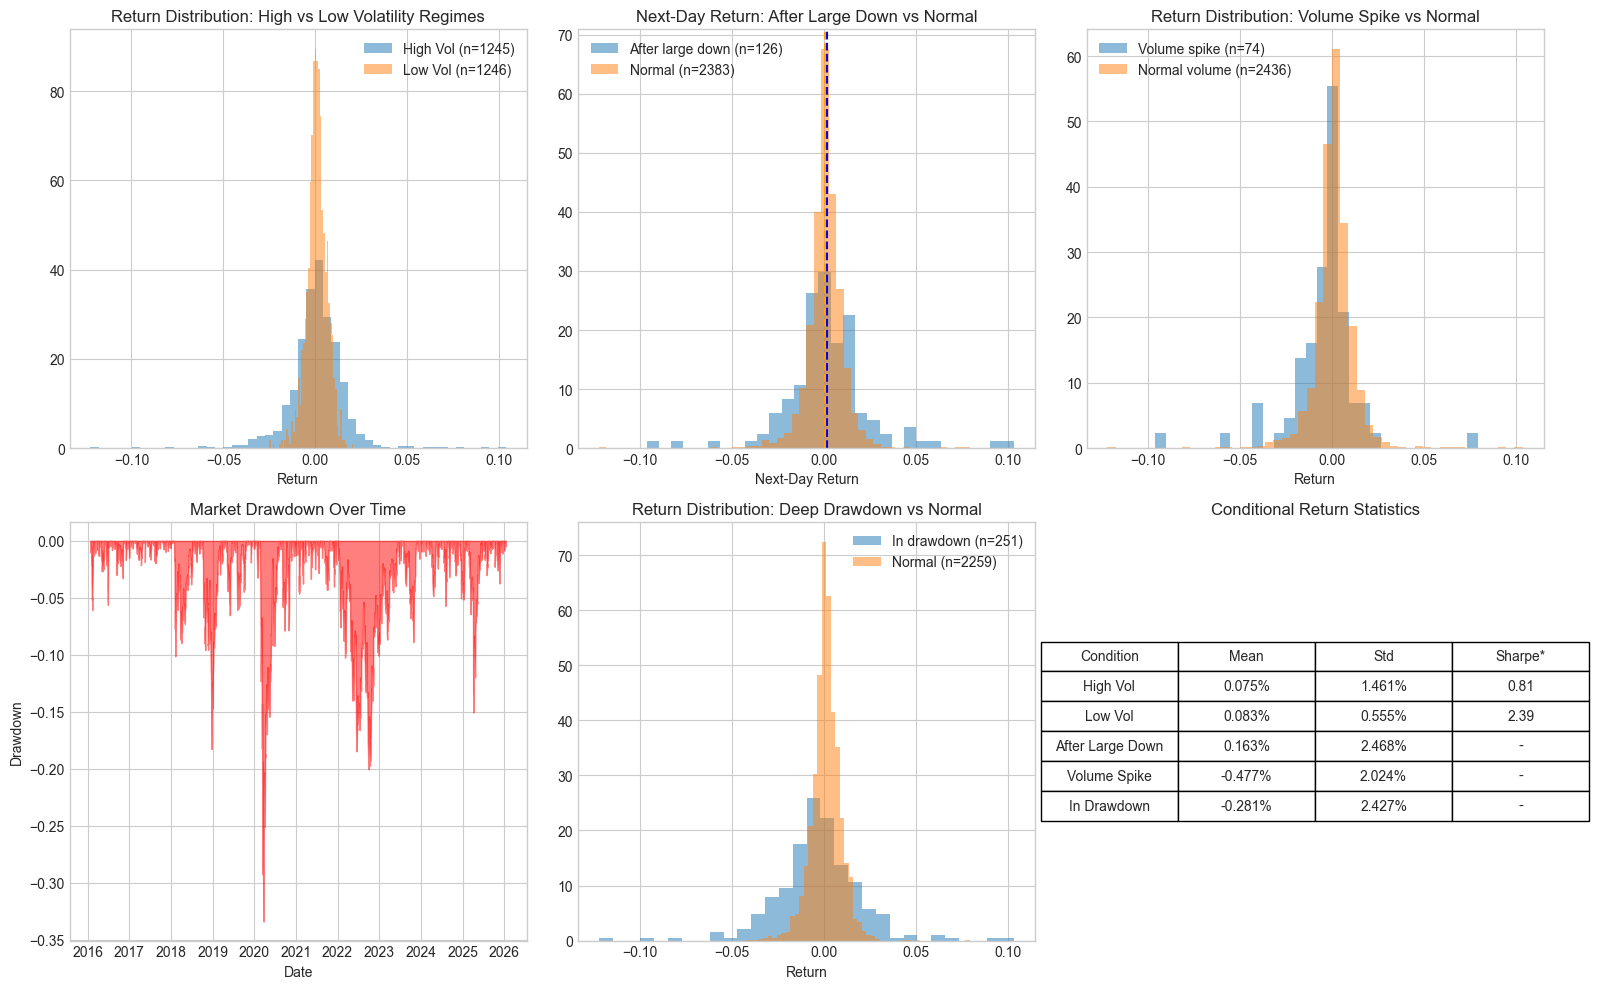


📊 CONDITIONAL BEHAVIOR SUMMARY:
  High vol mean: 0.0746%, Low vol mean: 0.0833%
  After large down mean: 0.1628%
  Volume spike mean: -0.4767%


In [17]:
# =============================================================================
# 2.3 CONDITIONAL RETURN BEHAVIOR
# =============================================================================

print("="*70)
print("2.3 CONDITIONAL RETURN BEHAVIOR")
print("="*70)

# Aggregate market return and volatility
market_return = returns_pivot.mean(axis=1)
market_vol = returns_pivot.std(axis=1)
rolling_vol = market_return.rolling(20).std()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Condition 1: High vs Low Volatility Regimes
vol_median = rolling_vol.median()
high_vol_returns = market_return[rolling_vol > vol_median]
low_vol_returns = market_return[rolling_vol <= vol_median]

ax = axes[0, 0]
ax.hist(high_vol_returns, bins=50, alpha=0.5, density=True, label=f'High Vol (n={len(high_vol_returns)})')
ax.hist(low_vol_returns, bins=50, alpha=0.5, density=True, label=f'Low Vol (n={len(low_vol_returns)})')
ax.set_title('Return Distribution: High vs Low Volatility Regimes')
ax.set_xlabel('Return')
ax.legend()

# Condition 2: After large down moves
large_down_days = market_return < market_return.quantile(0.05)
returns_after_down = market_return.shift(-1)[large_down_days]
returns_normal = market_return.shift(-1)[~large_down_days]

ax = axes[0, 1]
ax.hist(returns_after_down.dropna(), bins=30, alpha=0.5, density=True, label=f'After large down (n={len(returns_after_down.dropna())})')
ax.hist(returns_normal.dropna(), bins=50, alpha=0.5, density=True, label=f'Normal (n={len(returns_normal.dropna())})')
ax.axvline(returns_after_down.mean(), color='blue', linestyle='--')
ax.axvline(returns_normal.mean(), color='orange', linestyle='--')
ax.set_title('Next-Day Return: After Large Down vs Normal')
ax.set_xlabel('Next-Day Return')
ax.legend()

# Condition 3: Volume spikes
total_volume = volume_pivot.sum(axis=1)
volume_ma = total_volume.rolling(20).mean()
volume_spike = total_volume > (volume_ma * 1.5)

returns_vol_spike = market_return[volume_spike]
returns_normal_vol = market_return[~volume_spike]

ax = axes[0, 2]
ax.hist(returns_vol_spike.dropna(), bins=30, alpha=0.5, density=True, label=f'Volume spike (n={len(returns_vol_spike.dropna())})')
ax.hist(returns_normal_vol.dropna(), bins=50, alpha=0.5, density=True, label=f'Normal volume (n={len(returns_normal_vol.dropna())})')
ax.set_title('Return Distribution: Volume Spike vs Normal')
ax.set_xlabel('Return')
ax.legend()

# Drawdown analysis
cumulative_return = (1 + market_return).cumprod()
rolling_max = cumulative_return.cummax()
drawdown = (cumulative_return - rolling_max) / rolling_max

ax = axes[1, 0]
ax.fill_between(drawdown.index, drawdown.values, 0, alpha=0.5, color='red')
ax.set_title('Market Drawdown Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Drawdown')

# Returns during drawdown periods
deep_drawdown = drawdown < drawdown.quantile(0.1)
returns_in_dd = market_return[deep_drawdown]
returns_out_dd = market_return[~deep_drawdown]

ax = axes[1, 1]
ax.hist(returns_in_dd.dropna(), bins=30, alpha=0.5, density=True, label=f'In drawdown (n={len(returns_in_dd.dropna())})')
ax.hist(returns_out_dd.dropna(), bins=50, alpha=0.5, density=True, label=f'Normal (n={len(returns_out_dd.dropna())})')
ax.set_title('Return Distribution: Deep Drawdown vs Normal')
ax.set_xlabel('Return')
ax.legend()

# Summary statistics table
ax = axes[1, 2]
ax.axis('off')
summary_data = [
    ['Condition', 'Mean', 'Std', 'Sharpe*'],
    ['High Vol', f'{high_vol_returns.mean()*100:.3f}%', f'{high_vol_returns.std()*100:.3f}%', f'{high_vol_returns.mean()/high_vol_returns.std()*np.sqrt(252):.2f}'],
    ['Low Vol', f'{low_vol_returns.mean()*100:.3f}%', f'{low_vol_returns.std()*100:.3f}%', f'{low_vol_returns.mean()/low_vol_returns.std()*np.sqrt(252):.2f}'],
    ['After Large Down', f'{returns_after_down.mean()*100:.3f}%', f'{returns_after_down.std()*100:.3f}%', '-'],
    ['Volume Spike', f'{returns_vol_spike.mean()*100:.3f}%', f'{returns_vol_spike.std()*100:.3f}%', '-'],
    ['In Drawdown', f'{returns_in_dd.mean()*100:.3f}%', f'{returns_in_dd.std()*100:.3f}%', '-'],
]
table = ax.table(cellText=summary_data, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
ax.set_title('Conditional Return Statistics')

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES / '2_3_conditional_returns.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 CONDITIONAL BEHAVIOR SUMMARY:")
print(f"  High vol mean: {high_vol_returns.mean()*100:.4f}%, Low vol mean: {low_vol_returns.mean()*100:.4f}%")
print(f"  After large down mean: {returns_after_down.mean()*100:.4f}%")
print(f"  Volume spike mean: {returns_vol_spike.mean()*100:.4f}%")

Returns exhibit little unconditional predictability, but their distributional shape changes materially across volatility, liquidity, and drawdown regimes. Conditional regimes are primarily characterized by changes in risk and tail behavior rather than stable shifts in expected return.

### 2.4 Return-Level Synthesis

**OBSERVATIONS:**
- Returns are non-normal (fat tails, excess kurtosis)
- Returns show minimal autocorrelation (near-efficient)
- Absolute returns show strong autocorrelation (volatility clusters)
- Conditional return behavior varies by regime

**ECONOMIC EXPLANATION:**
- Fat tails: Jump risk, information clustering
- No return autocorrelation: Market efficiency, arbitrage
- Volatility clustering: ARCH effects, feedback loops

**RULES OUT:**
- ❌ Simple momentum on raw returns (weak autocorrelation)
- ❌ Gaussian risk models
- ❌ Static position sizing

**ENABLES:**
- ✅ Volatility-timing strategies
- ✅ Regime-conditional signals
- ✅ GARCH-family volatility models
- ✅ Tail-risk aware features

---

## 3. Volatility Structure

### Key Questions:
- How does volatility cluster and persist?
- Is volatility synchronized across assets?
- Are there regime transitions in volatility-of-volatility?

3.1 VOLATILITY CLUSTERING & PERSISTENCE


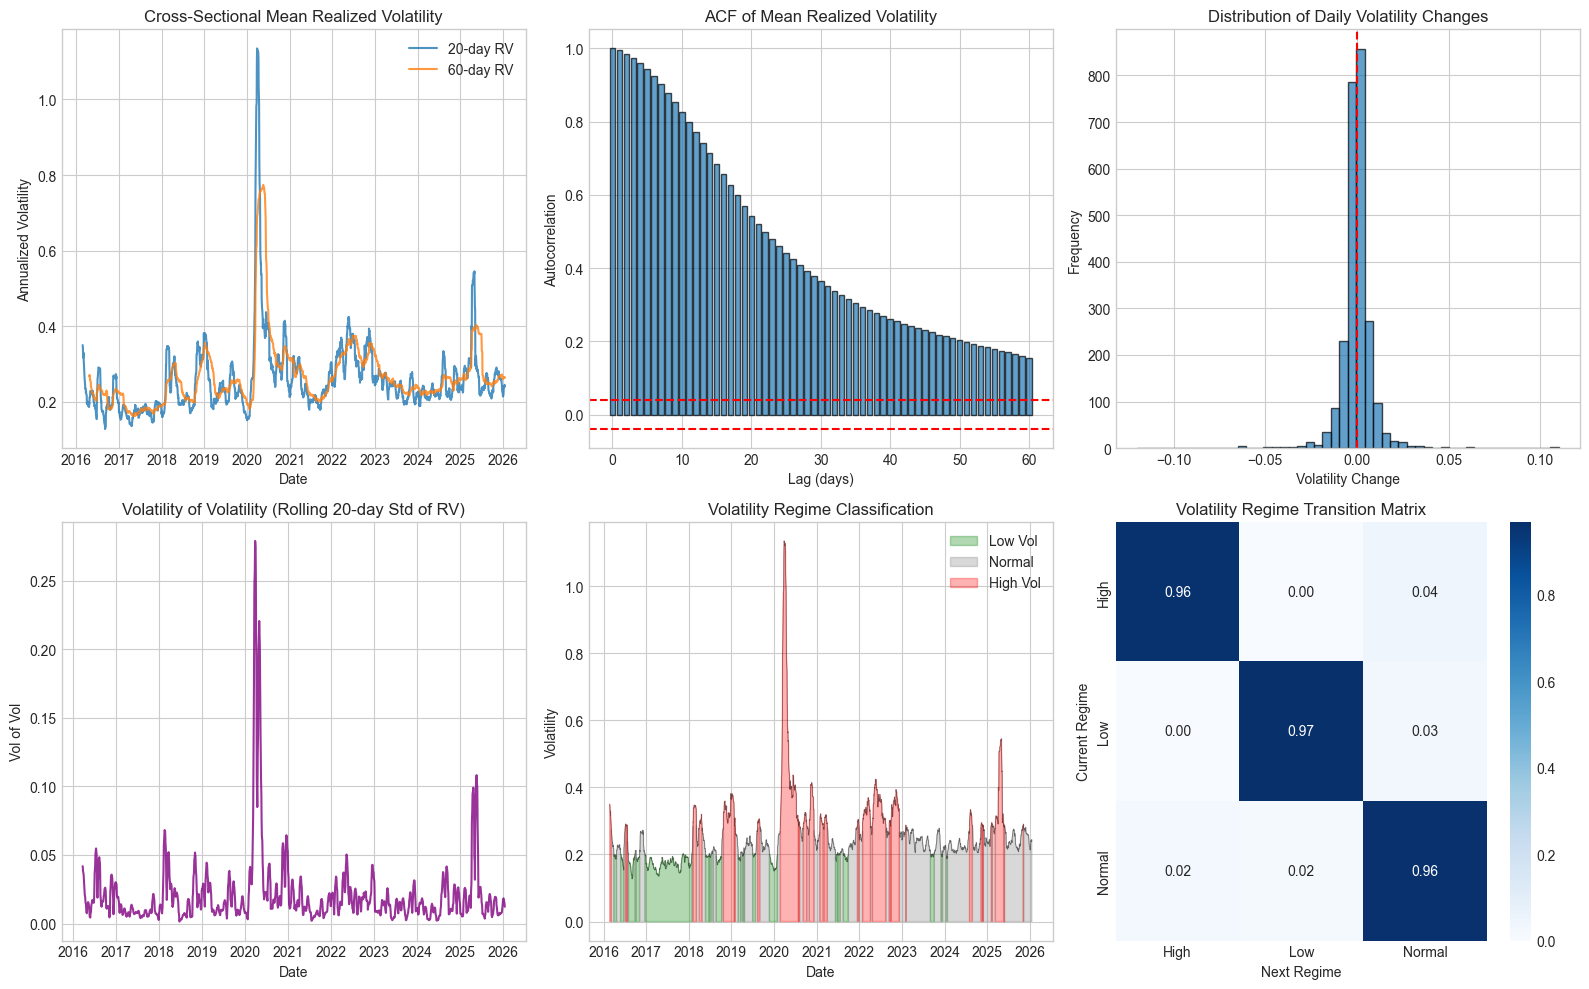


📊 VOLATILITY PERSISTENCE METRICS:
  Volatility ACF lag-1: 0.9948
  Estimated half-life: 131.7 days
  Time in Low Vol regime: 24.8%
  Time in High Vol regime: 24.8%


In [18]:
# =============================================================================
# 3.1 VOLATILITY CLUSTERING & PERSISTENCE
# =============================================================================

print("="*70)
print("3.1 VOLATILITY CLUSTERING & PERSISTENCE")
print("="*70)

# Compute various volatility measures
rv_20 = returns_pivot.rolling(20).std() * np.sqrt(252)  # 20-day realized vol
rv_60 = returns_pivot.rolling(60).std() * np.sqrt(252)  # 60-day realized vol

# Cross-sectional mean volatility
mean_vol_20 = rv_20.mean(axis=1)
mean_vol_60 = rv_60.mean(axis=1)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Time series of mean volatility
ax = axes[0, 0]
ax.plot(mean_vol_20.index, mean_vol_20.values, alpha=0.8, label='20-day RV')
ax.plot(mean_vol_60.index, mean_vol_60.values, alpha=0.8, label='60-day RV')
ax.set_title('Cross-Sectional Mean Realized Volatility')
ax.set_xlabel('Date')
ax.set_ylabel('Annualized Volatility')
ax.legend()

# Volatility ACF
ax = axes[0, 1]
vol_acf = acf(mean_vol_20.dropna(), nlags=60, fft=True)
ax.bar(range(len(vol_acf)), vol_acf, alpha=0.7, edgecolor='black')
ax.axhline(1.96/np.sqrt(len(mean_vol_20.dropna())), color='red', linestyle='--')
ax.axhline(-1.96/np.sqrt(len(mean_vol_20.dropna())), color='red', linestyle='--')
ax.set_title('ACF of Mean Realized Volatility')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Autocorrelation')

# Volatility persistence - half-life estimation
ax = axes[0, 2]
vol_changes = mean_vol_20.diff().dropna()
ax.hist(vol_changes, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--')
ax.set_title('Distribution of Daily Volatility Changes')
ax.set_xlabel('Volatility Change')
ax.set_ylabel('Frequency')

# Volatility of volatility
vol_of_vol = mean_vol_20.rolling(20).std()
ax = axes[1, 0]
ax.plot(vol_of_vol.index, vol_of_vol.values, alpha=0.8, color='purple')
ax.set_title('Volatility of Volatility (Rolling 20-day Std of RV)')
ax.set_xlabel('Date')
ax.set_ylabel('Vol of Vol')

# Volatility regime identification (simple threshold)
ax = axes[1, 1]
vol_percentiles = mean_vol_20.quantile([0.25, 0.75])
low_vol_regime = mean_vol_20 <= vol_percentiles[0.25]
high_vol_regime = mean_vol_20 >= vol_percentiles[0.75]
normal_regime = ~low_vol_regime & ~high_vol_regime

ax.fill_between(mean_vol_20.index, 0, mean_vol_20.values, 
                where=low_vol_regime, alpha=0.3, color='green', label='Low Vol')
ax.fill_between(mean_vol_20.index, 0, mean_vol_20.values, 
                where=normal_regime, alpha=0.3, color='gray', label='Normal')
ax.fill_between(mean_vol_20.index, 0, mean_vol_20.values, 
                where=high_vol_regime, alpha=0.3, color='red', label='High Vol')
ax.plot(mean_vol_20.index, mean_vol_20.values, color='black', alpha=0.5, lw=0.5)
ax.set_title('Volatility Regime Classification')
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
ax.legend()

# Regime persistence (transition matrix)
ax = axes[1, 2]
regime = pd.Series(index=mean_vol_20.index, dtype=str)
regime[low_vol_regime] = 'Low'
regime[high_vol_regime] = 'High'
regime[normal_regime] = 'Normal'
regime = regime.dropna()

transitions = pd.crosstab(regime, regime.shift(-1), normalize='index')
sns.heatmap(transitions, annot=True, fmt='.2f', cmap='Blues', ax=ax)
ax.set_title('Volatility Regime Transition Matrix')
ax.set_xlabel('Next Regime')
ax.set_ylabel('Current Regime')

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES / '3_1_volatility_clustering.png', dpi=150, bbox_inches='tight')
plt.show()

# Compute persistence statistics
vol_acf_1 = vol_acf[1]
half_life = -np.log(2) / np.log(vol_acf_1) if vol_acf_1 > 0 else np.nan

print(f"\n📊 VOLATILITY PERSISTENCE METRICS:")
print(f"  Volatility ACF lag-1: {vol_acf_1:.4f}")
print(f"  Estimated half-life: {half_life:.1f} days")
print(f"  Time in Low Vol regime: {low_vol_regime.sum()/len(low_vol_regime)*100:.1f}%")
print(f"  Time in High Vol regime: {high_vol_regime.sum()/len(high_vol_regime)*100:.1f}%")

3.2 VOLATILITY SYNCHRONIZATION ACROSS ASSETS


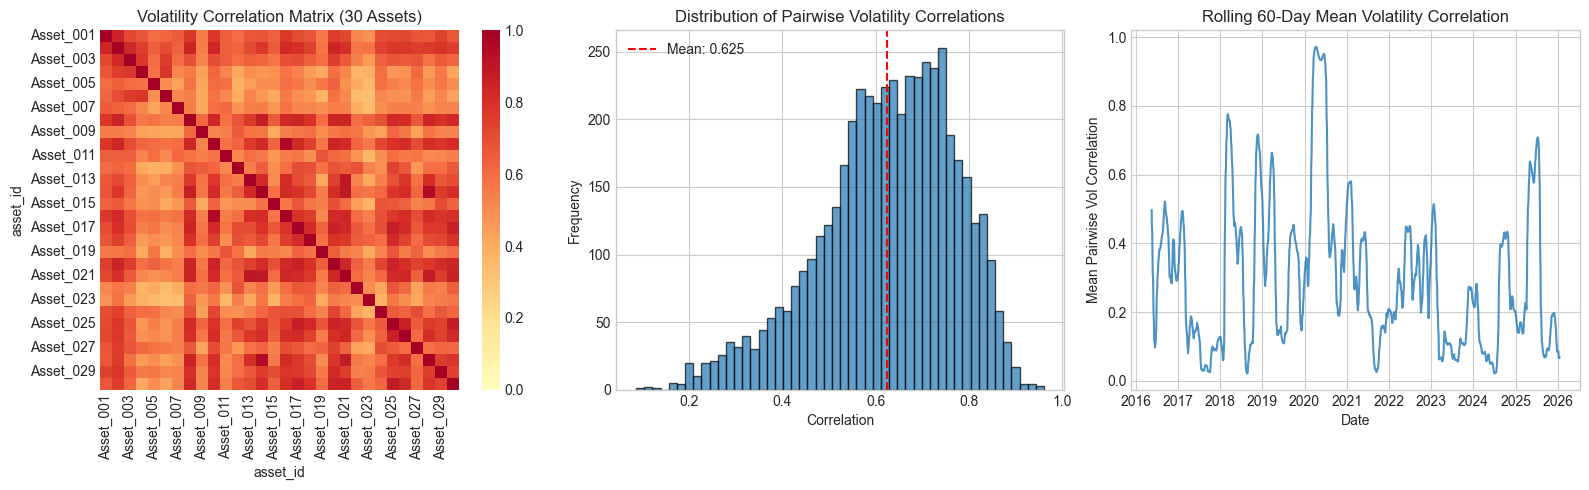


📊 VOLATILITY SYNCHRONIZATION METRICS:
  Mean pairwise vol correlation: 0.6250
  Median pairwise vol correlation: 0.6389
  Min/Max vol correlation: 0.0873 / 0.9608


In [19]:
# =============================================================================
# 3.2 VOLATILITY SYNCHRONIZATION ACROSS ASSETS
# =============================================================================

print("="*70)
print("3.2 VOLATILITY SYNCHRONIZATION ACROSS ASSETS")
print("="*70)

# Compute pairwise volatility correlations
vol_corr_matrix = rv_20.dropna().corr()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Volatility correlation heatmap (sample)
ax = axes[0]
sample_corr = vol_corr_matrix.iloc[:30, :30]
sns.heatmap(sample_corr, ax=ax, cmap='RdYlBu_r', center=0, vmin=0, vmax=1)
ax.set_title('Volatility Correlation Matrix (30 Assets)')

# Distribution of pairwise volatility correlations
ax = axes[1]
upper_tri = vol_corr_matrix.where(np.triu(np.ones(vol_corr_matrix.shape), k=1).astype(bool))
vol_corr_values = upper_tri.values.flatten()
vol_corr_values = vol_corr_values[~np.isnan(vol_corr_values)]
ax.hist(vol_corr_values, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(vol_corr_values.mean(), color='red', linestyle='--', label=f'Mean: {vol_corr_values.mean():.3f}')
ax.set_title('Distribution of Pairwise Volatility Correlations')
ax.set_xlabel('Correlation')
ax.set_ylabel('Frequency')
ax.legend()

# Rolling average volatility correlation (synchronization measure)
ax = axes[2]
rolling_vol_corr = []
window = 60
for i in range(window, len(rv_20)):
    chunk = rv_20.iloc[i-window:i].dropna(axis=1)
    if chunk.shape[1] > 10:
        corr = chunk.corr()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)).values.flatten()
        upper = upper[~np.isnan(upper)]
        rolling_vol_corr.append({'date': rv_20.index[i], 'mean_corr': upper.mean()})

rolling_vol_corr_df = pd.DataFrame(rolling_vol_corr).set_index('date')
ax.plot(rolling_vol_corr_df.index, rolling_vol_corr_df['mean_corr'].values, alpha=0.8)
ax.set_title('Rolling 60-Day Mean Volatility Correlation')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Pairwise Vol Correlation')

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES / '3_2_volatility_synchronization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 VOLATILITY SYNCHRONIZATION METRICS:")
print(f"  Mean pairwise vol correlation: {vol_corr_values.mean():.4f}")
print(f"  Median pairwise vol correlation: {np.median(vol_corr_values):.4f}")
print(f"  Min/Max vol correlation: {vol_corr_values.min():.4f} / {vol_corr_values.max():.4f}")

The S&P 500 universe exhibits strong volatility persistence, with realized volatility displaying long memory over horizons exceeding 50 trading days. Volatility regimes are highly persistent, as evidenced by a strongly diagonal transition matrix, while changes in volatility are heavy-tailed and discontinuous. This suggests that while risk levels are predictable, regime transitions are abrupt, motivating regime-aware feature construction and conservative exposure scaling.

### 3.3 Volatility Structure Synthesis

**OBSERVATIONS:**
- Volatility is highly persistent (slow mean reversion)
- Strong synchronization across assets
- Regime transitions are sticky (high diagonal in transition matrix)

**ECONOMIC EXPLANATION:**
- Common factor exposure (market risk)
- Correlated information arrival
- Feedback through leverage and margin constraints

**RULES OUT:**
- ❌ Asset-specific volatility timing in isolation
- ❌ Ignoring regime in signal generation

**ENABLES:**
- ✅ Market-wide volatility factor for risk scaling
- ✅ Regime-conditional position sizing
- ✅ Volatility mean-reversion features (long-horizon)
- ✅ Cross-asset volatility dispersion as a feature

---

## 4. Correlation & Dependence

### Key Questions:
- How do correlations evolve over time?
- How does correlation behave during stress?
- Is dependence more complex than linear correlation?

4.1 CORRELATION DYNAMICS


Computing rolling correlations: 100%|██████████| 2450/2450 [00:03<00:00, 754.88it/s]


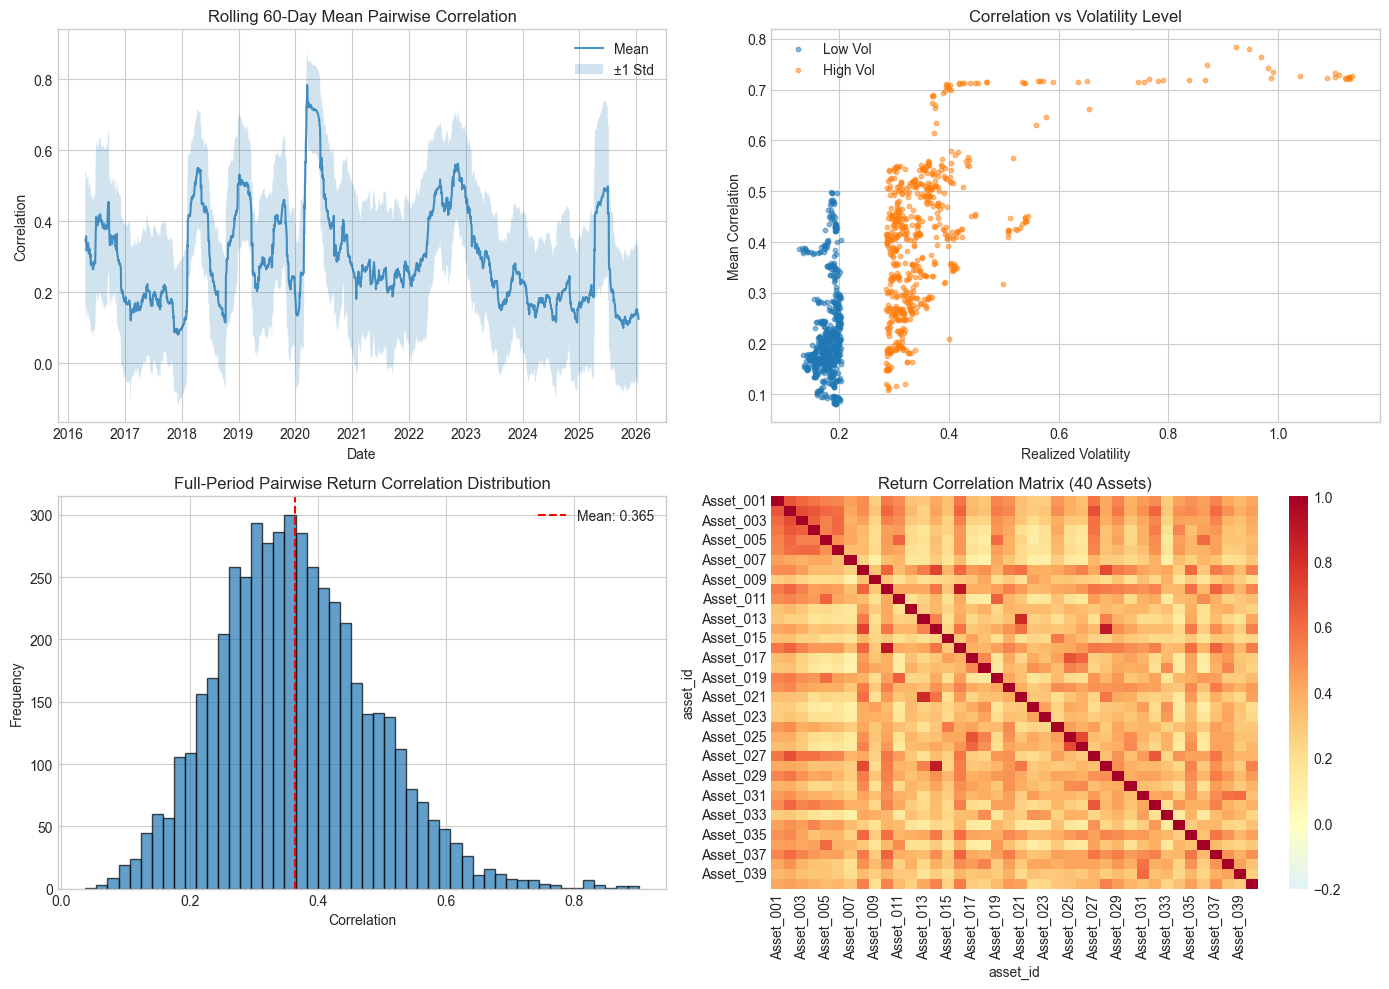


📊 CORRELATION DYNAMICS:
  Full-period mean correlation: 0.3651
  Correlation during high vol: 0.4151
  Correlation during low vol: 0.2220
  Correlation increase during stress: 87.0%


In [ ]:
# =============================================================================
# 4.1 CORRELATION DYNAMICS
# =============================================================================

print("="*70)
print("4.1 CORRELATION DYNAMICS")
print("="*70)

# Compute rolling average correlation
def compute_rolling_avg_corr(returns_df, window=60):
    rolling_corrs = []
    for i in tqdm(range(window, len(returns_df)), desc="Computing rolling correlations"):
        chunk = returns_df.iloc[i-window:i]
        corr = chunk.corr()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)).values.flatten()
        upper = upper[~np.isnan(upper)]
        rolling_corrs.append({
            'date': returns_df.index[i],
            'mean_corr': upper.mean(),
            'std_corr': upper.std(),
            'median_corr': np.median(upper)
        })
    return pd.DataFrame(rolling_corrs).set_index('date')

rolling_corr_df = compute_rolling_avg_corr(returns_pivot, window=60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Rolling average correlation
ax = axes[0, 0]
ax.plot(rolling_corr_df.index, rolling_corr_df['mean_corr'], alpha=0.8, label='Mean')
ax.fill_between(rolling_corr_df.index, 
                rolling_corr_df['mean_corr'] - rolling_corr_df['std_corr'],
                rolling_corr_df['mean_corr'] + rolling_corr_df['std_corr'],
                alpha=0.2, label='±1 Std')
ax.set_title('Rolling 60-Day Mean Pairwise Correlation')
ax.set_xlabel('Date')
ax.set_ylabel('Correlation')
ax.legend()

# Correlation during stress (high vol periods)
ax = axes[0, 1]
aligned_vol = mean_vol_20.reindex(rolling_corr_df.index)
high_vol_mask = aligned_vol > aligned_vol.quantile(0.75)
low_vol_mask = aligned_vol < aligned_vol.quantile(0.25)

ax.scatter(aligned_vol[low_vol_mask], rolling_corr_df['mean_corr'][low_vol_mask], 
           alpha=0.5, label='Low Vol', s=10)
ax.scatter(aligned_vol[high_vol_mask], rolling_corr_df['mean_corr'][high_vol_mask], 
           alpha=0.5, label='High Vol', s=10)
ax.set_title('Correlation vs Volatility Level')
ax.set_xlabel('Realized Volatility')
ax.set_ylabel('Mean Correlation')
ax.legend()

# Full correlation distribution
ax = axes[1, 0]
full_corr = returns_pivot.corr()
upper_tri = full_corr.where(np.triu(np.ones(full_corr.shape), k=1).astype(bool))
all_corr_vals = upper_tri.values.flatten()
all_corr_vals = all_corr_vals[~np.isnan(all_corr_vals)]

ax.hist(all_corr_vals, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(all_corr_vals.mean(), color='red', linestyle='--', label=f'Mean: {all_corr_vals.mean():.3f}')
ax.set_title('Full-Period Pairwise Return Correlation Distribution')
ax.set_xlabel('Correlation')
ax.set_ylabel('Frequency')
ax.legend()

# Correlation heatmap (clustered)
ax = axes[1, 1]
sns.heatmap(full_corr.iloc[:40, :40], ax=ax, cmap='RdYlBu_r', center=0, vmin=-0.2, vmax=1)
ax.set_title('Return Correlation Matrix (40 Assets)')

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES / '4_1_correlation_dynamics.png', dpi=150, bbox_inches='tight')
plt.show()

# Correlation during stress quantification
corr_high_vol = rolling_corr_df['mean_corr'][high_vol_mask].mean()
corr_low_vol = rolling_corr_df['mean_corr'][low_vol_mask].mean()

print(f"\n📊 CORRELATION DYNAMICS:")
print(f"  Full-period mean correlation: {all_corr_vals.mean():.4f}")
print(f"  Correlation during high vol: {corr_high_vol:.4f}")
print(f"  Correlation during low vol: {corr_low_vol:.4f}")
print(f"  Correlation increase during stress: {(corr_high_vol - corr_low_vol)/corr_low_vol*100:.1f}%")

The equity universe exhibits regime-dependent correlation structure, with sharply higher and more homogeneous correlations during high-volatility periods.Static correlation estimates therefore fail to capture the true dependency structure, motivating regime-aware and time-localized relational modeling.

4.2 CORRELATION INSTABILITY


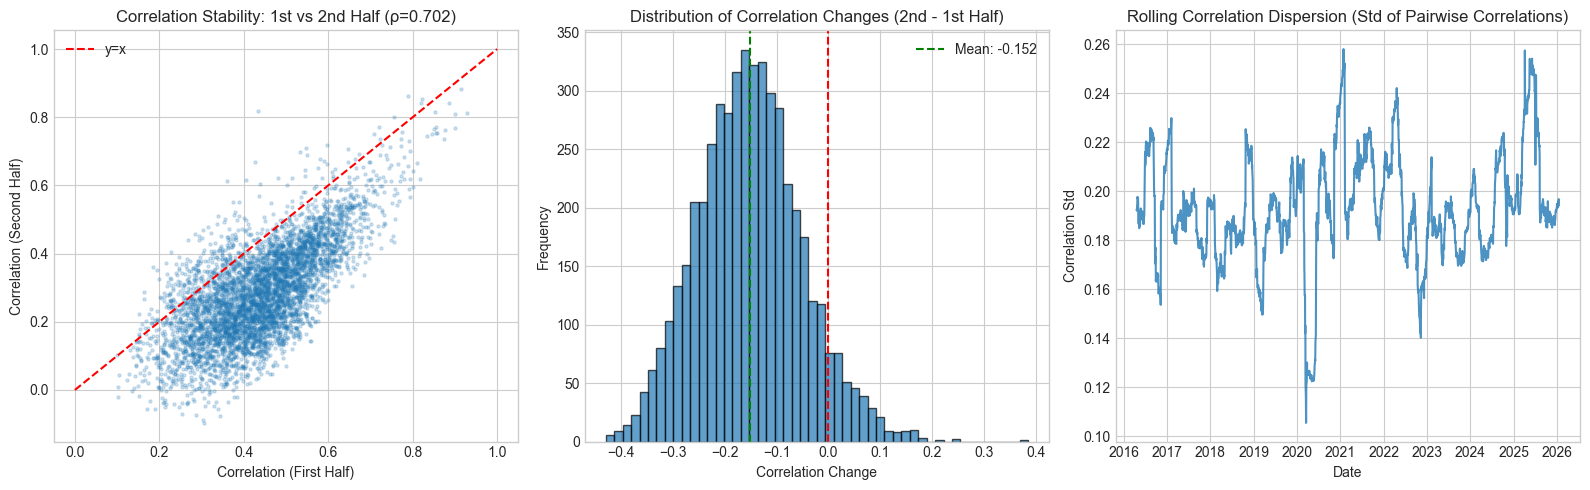


📊 CORRELATION INSTABILITY METRICS:
  Correlation stability (1st vs 2nd half): 0.7024
  Mean correlation change: -0.1516
  Std of correlation change: 0.1010
  Pairs with correlation change > 0.2: 1606 (32.4%)


In [21]:
# =============================================================================
# 4.2 CORRELATION INSTABILITY
# =============================================================================

print("="*70)
print("4.2 CORRELATION INSTABILITY")
print("="*70)

# Compare correlation in first half vs second half
mid_point = len(returns_pivot) // 2
first_half = returns_pivot.iloc[:mid_point]
second_half = returns_pivot.iloc[mid_point:]

corr_first = first_half.corr()
corr_second = second_half.corr()

# Flatten upper triangles
def get_upper_tri_flat(corr_matrix):
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    return upper.values.flatten()[~np.isnan(upper.values.flatten())]

corr_first_flat = get_upper_tri_flat(corr_first)
corr_second_flat = get_upper_tri_flat(corr_second)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Scatter: first half vs second half
ax = axes[0]
ax.scatter(corr_first_flat, corr_second_flat, alpha=0.2, s=5)
ax.plot([0, 1], [0, 1], 'r--', label='y=x')
corr_stability = np.corrcoef(corr_first_flat, corr_second_flat)[0, 1]
ax.set_title(f'Correlation Stability: 1st vs 2nd Half (ρ={corr_stability:.3f})')
ax.set_xlabel('Correlation (First Half)')
ax.set_ylabel('Correlation (Second Half)')
ax.legend()

# Change distribution
ax = axes[1]
corr_change = corr_second_flat - corr_first_flat
ax.hist(corr_change, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--')
ax.axvline(corr_change.mean(), color='green', linestyle='--', label=f'Mean: {corr_change.mean():.3f}')
ax.set_title('Distribution of Correlation Changes (2nd - 1st Half)')
ax.set_xlabel('Correlation Change')
ax.set_ylabel('Frequency')
ax.legend()

# Rolling correlation volatility
ax = axes[2]
ax.plot(rolling_corr_df.index, rolling_corr_df['std_corr'], alpha=0.8)
ax.set_title('Rolling Correlation Dispersion (Std of Pairwise Correlations)')
ax.set_xlabel('Date')
ax.set_ylabel('Correlation Std')

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES / '4_2_correlation_instability.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 CORRELATION INSTABILITY METRICS:")
print(f"  Correlation stability (1st vs 2nd half): {corr_stability:.4f}")
print(f"  Mean correlation change: {corr_change.mean():.4f}")
print(f"  Std of correlation change: {corr_change.std():.4f}")
print(f"  Pairs with correlation change > 0.2: {(np.abs(corr_change) > 0.2).sum()} ({(np.abs(corr_change) > 0.2).mean()*100:.1f}%)")

Pairwise correlations exhibit moderate stability across long horizons (ρ ≈ 0.70) but undergo substantial drift, with over 30% of asset pairs experiencing correlation changes exceeding 0.2. Furthermore, the dispersion of correlations varies significantly over time, indicating that relational structure is regime-dependent rather than static. These findings suggest that while relative-value structure exists, it must be modeled adaptively and conditioned on market state.

### 4.3 Correlation & Dependence Synthesis

**OBSERVATIONS:**
- Correlations increase during stress (diversification breaks down when needed most)
- Correlations are moderately stable but shift over multi-year horizons
- Correlation dispersion is time-varying

**ECONOMIC EXPLANATION:**
- Flight to quality / risk-off behavior
- Common factor dominance during stress
- Structural economic shifts over long horizons

**RULES OUT:**
- ❌ Static correlation-based diversification
- ❌ Pair trading with fixed thresholds

**ENABLES:**
- ✅ Dynamic correlation modeling
- ✅ Correlation regime features
- ✅ Rolling/adaptive covariance estimation
- ✅ Correlation dispersion as market stress indicator

---

## 5. Cross-Sectional Structure

### Key Questions:
- How dispersed are cross-sectional returns?
- How stable are asset rankings over time?
- What does this imply for ranking-based strategies?

5.1 CROSS-SECTIONAL DISPERSION


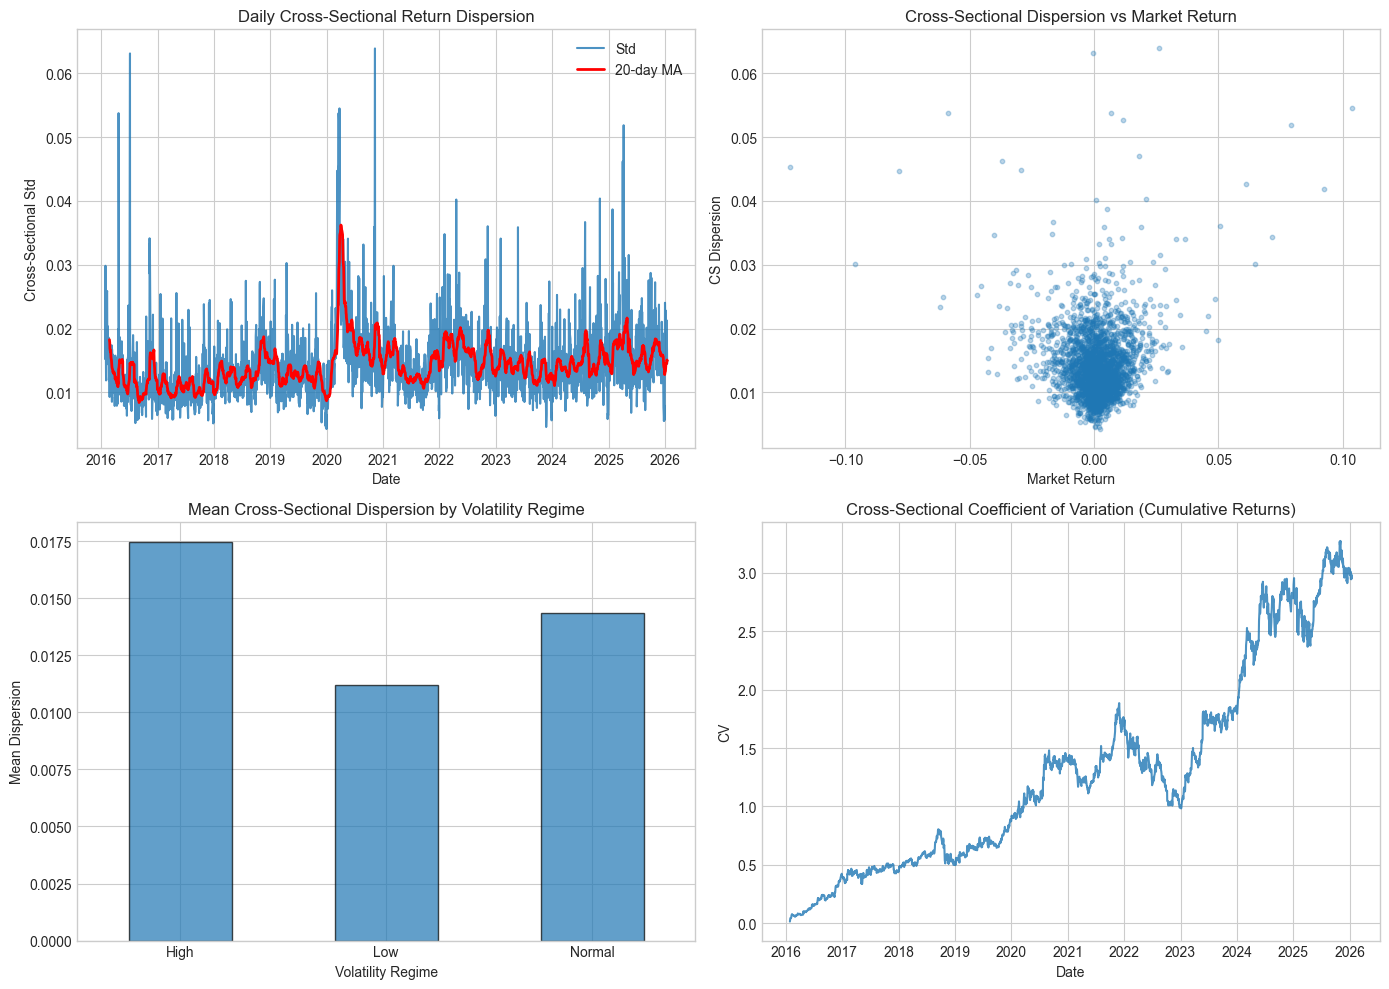


📊 CROSS-SECTIONAL DISPERSION METRICS:
  Mean daily dispersion: 1.4340%
  Dispersion correlation with |market return|: 0.4471


In [22]:
# =============================================================================
# 5.1 CROSS-SECTIONAL DISPERSION
# =============================================================================

print("="*70)
print("5.1 CROSS-SECTIONAL DISPERSION")
print("="*70)

# Daily cross-sectional dispersion
cs_dispersion = returns_pivot.std(axis=1)
cs_range = returns_pivot.max(axis=1) - returns_pivot.min(axis=1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Dispersion time series
ax = axes[0, 0]
ax.plot(cs_dispersion.index, cs_dispersion.values, alpha=0.8, label='Std')
ax.plot(cs_dispersion.rolling(20).mean().index, cs_dispersion.rolling(20).mean().values, 
        color='red', lw=2, label='20-day MA')
ax.set_title('Daily Cross-Sectional Return Dispersion')
ax.set_xlabel('Date')
ax.set_ylabel('Cross-Sectional Std')
ax.legend()

# Dispersion vs market return
ax = axes[0, 1]
ax.scatter(market_return.values, cs_dispersion.values, alpha=0.3, s=10)
ax.set_title('Cross-Sectional Dispersion vs Market Return')
ax.set_xlabel('Market Return')
ax.set_ylabel('CS Dispersion')

# Dispersion by regime
ax = axes[1, 0]
aligned_regime = regime.reindex(cs_dispersion.index)
dispersion_by_regime = cs_dispersion.groupby(aligned_regime).mean()
dispersion_by_regime.plot(kind='bar', ax=ax, edgecolor='black', alpha=0.7)
ax.set_title('Mean Cross-Sectional Dispersion by Volatility Regime')
ax.set_xlabel('Volatility Regime')
ax.set_ylabel('Mean Dispersion')
ax.tick_params(axis='x', rotation=0)

# Cumulative return dispersion (tracking divergence)
ax = axes[1, 1]
cumulative_returns = (1 + returns_pivot).cumprod()
cs_cumret_std = cumulative_returns.std(axis=1) / cumulative_returns.mean(axis=1)
ax.plot(cs_cumret_std.index, cs_cumret_std.values, alpha=0.8)
ax.set_title('Cross-Sectional Coefficient of Variation (Cumulative Returns)')
ax.set_xlabel('Date')
ax.set_ylabel('CV')

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES / '5_1_cross_sectional_dispersion.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 CROSS-SECTIONAL DISPERSION METRICS:")
print(f"  Mean daily dispersion: {cs_dispersion.mean()*100:.4f}%")
print(f"  Dispersion correlation with |market return|: {np.corrcoef(cs_dispersion.values, np.abs(market_return.values))[0,1]:.4f}")

Cross-sectional dispersion exhibits strong time variation and rises significantly during market stress, with a correlation of ~0.45 with absolute market returns. This indicates that periods of heightened risk are also periods of increased relative differentiation across assets, motivating cross-sectional ranking strategies conditioned on volatility regimes.

5.2 RANK STABILITY & AUTOCORRELATION


Computing rank ACF: 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


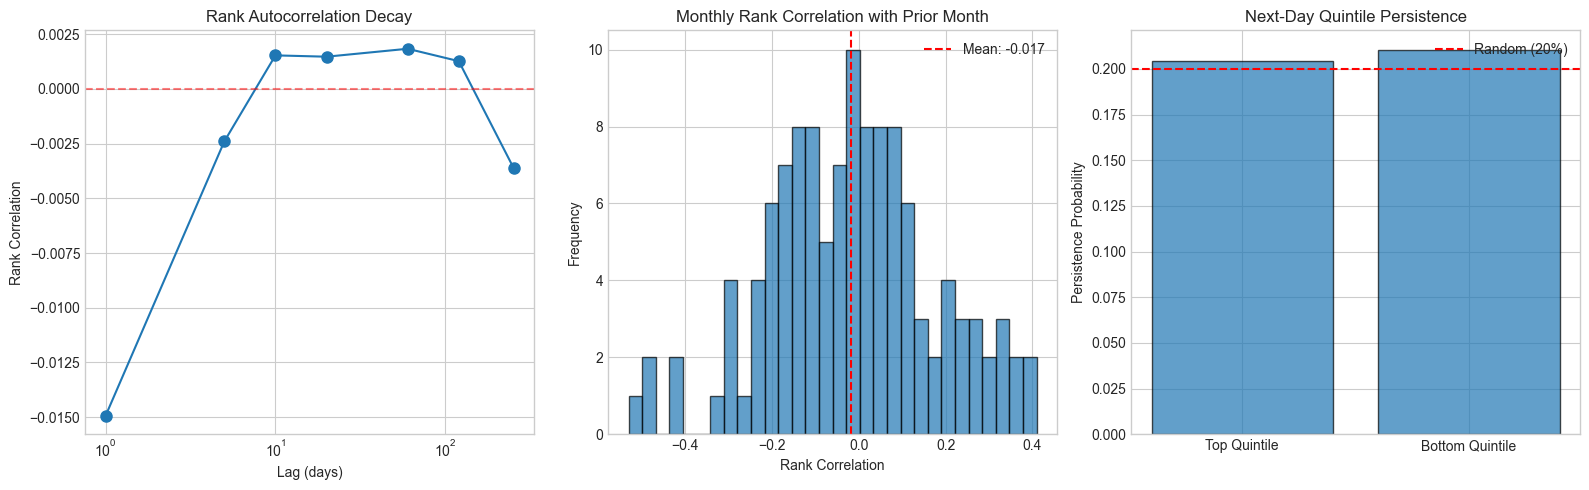


📊 RANK STABILITY METRICS:
  Rank ACF at lag   1: -0.0149
  Rank ACF at lag   5: -0.0024
  Rank ACF at lag  10: 0.0015
  Rank ACF at lag  20: 0.0015
  Rank ACF at lag  60: 0.0018
  Rank ACF at lag 120: 0.0013
  Rank ACF at lag 252: -0.0036

  Top quintile 1-day persistence: 20.4%
  Bottom quintile 1-day persistence: 21.1%


In [23]:
# =============================================================================
# 5.2 RANK STABILITY & AUTOCORRELATION
# =============================================================================

print("="*70)
print("5.2 RANK STABILITY & AUTOCORRELATION")
print("="*70)

# Compute daily ranks
daily_ranks = returns_pivot.rank(axis=1)

# Rank autocorrelation at various horizons
def compute_rank_autocorr(ranks_df, lag):
    """Compute mean cross-sectional rank autocorrelation at given lag."""
    correlations = []
    for i in range(lag, len(ranks_df)):
        corr = ranks_df.iloc[i].corr(ranks_df.iloc[i-lag])
        if not np.isnan(corr):
            correlations.append(corr)
    return np.mean(correlations)

lags = [1, 5, 10, 20, 60, 120, 252]
rank_acf = {}
for lag in tqdm(lags, desc="Computing rank ACF"):
    rank_acf[lag] = compute_rank_autocorr(daily_ranks, lag)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Rank autocorrelation decay
ax = axes[0]
ax.plot(lags, [rank_acf[l] for l in lags], 'o-', markersize=8)
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.set_title('Rank Autocorrelation Decay')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Rank Correlation')
ax.set_xscale('log')

# Rolling monthly rank vs prior month rank
ax = axes[1]
monthly_returns = returns_pivot.resample('M').sum()
monthly_ranks = monthly_returns.rank(axis=1)
rank_corr_monthly = monthly_ranks.corrwith(monthly_ranks.shift(1), axis=1).dropna()
ax.hist(rank_corr_monthly.values, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(rank_corr_monthly.mean(), color='red', linestyle='--', label=f'Mean: {rank_corr_monthly.mean():.3f}')
ax.set_title('Monthly Rank Correlation with Prior Month')
ax.set_xlabel('Rank Correlation')
ax.set_ylabel('Frequency')
ax.legend()

# Top/Bottom quintile persistence
ax = axes[2]
quintile = daily_ranks.apply(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop'), axis=1)
top_quintile = (quintile == 4).astype(int)
bottom_quintile = (quintile == 0).astype(int)

# Probability of staying in same quintile next day
top_persistence = (top_quintile * top_quintile.shift(-1)).sum() / top_quintile.sum()
bottom_persistence = (bottom_quintile * bottom_quintile.shift(-1)).sum() / bottom_quintile.sum()

persistence_data = ['Top Quintile', 'Bottom Quintile']
persistence_vals = [top_persistence.mean(), bottom_persistence.mean()]
ax.bar(persistence_data, persistence_vals, edgecolor='black', alpha=0.7)
ax.axhline(0.2, color='red', linestyle='--', label='Random (20%)')
ax.set_title('Next-Day Quintile Persistence')
ax.set_ylabel('Persistence Probability')
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES / '5_2_rank_stability.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 RANK STABILITY METRICS:")
for lag, acf_val in rank_acf.items():
    print(f"  Rank ACF at lag {lag:3d}: {acf_val:.4f}")
print(f"\n  Top quintile 1-day persistence: {top_persistence.mean()*100:.1f}%")
print(f"  Bottom quintile 1-day persistence: {bottom_persistence.mean()*100:.1f}%")

Cross-sectional return ranks exhibit near-zero persistence across daily to annual horizons, with next-day quintile persistence indistinguishable from random. This indicates rapid rank reshuffling in liquid equities, ruling out naïve momentum or reversal strategies based on raw returns. Any viable cross-sectional signal must therefore rely on smoothed, multi-horizon, or conditionally activated features rather than instantaneous rankings.

### 5.3 Cross-Sectional Structure Synthesis

**OBSERVATIONS:**
- Cross-sectional dispersion is time-varying, higher during stress
- Daily ranks show very weak autocorrelation (near-random)
- Longer-horizon ranks (monthly) show moderate persistence

**ECONOMIC EXPLANATION:**
- Daily performance is largely noise
- Fundamental value emerges over longer horizons
- Dispersion spikes reflect information arrival / uncertainty

**RULES OUT:**
- ❌ Daily momentum/reversal on individual stocks
- ❌ Very short holding periods for cross-sectional strategies

**ENABLES:**
- ✅ Longer-horizon (weekly/monthly) cross-sectional signals
- ✅ Dispersion-timing strategies
- ✅ Rank-based features with appropriate lookback

---

## 6. Volume & Liquidity Dynamics

### Key Questions:
- How coupled is volume with volatility?
- Is volume behavior symmetric (up vs down moves)?
- What liquidity asymmetries exist?

6.1 VOLUME-VOLATILITY RELATIONSHIP


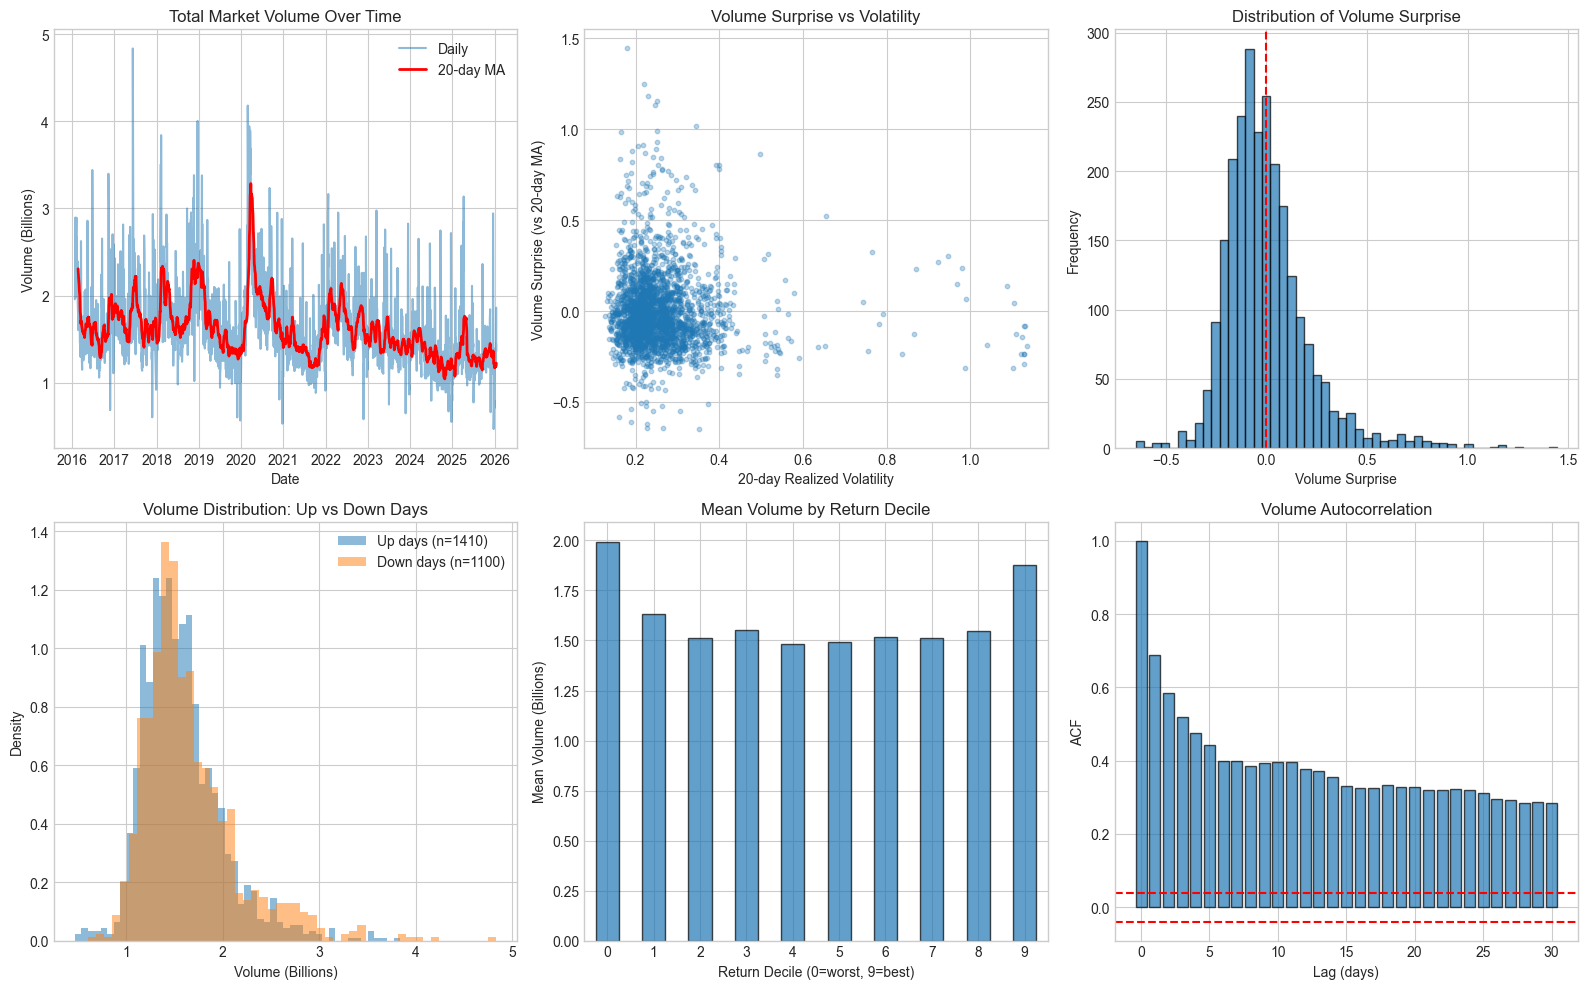


📊 VOLUME DYNAMICS METRICS:
  Volume-Volatility correlation: -0.0530
  Mean volume on up days: 1.58B
  Mean volume on down days: 1.66B
  Down/Up volume ratio: 1.052


In [25]:
# =============================================================================
# 6.1 VOLUME-VOLATILITY RELATIONSHIP (FIXED)
# =============================================================================

print("="*70)
print("6.1 VOLUME-VOLATILITY RELATIONSHIP")
print("="*70)

# Aggregate volume measures
total_volume = volume_pivot.sum(axis=1)
mean_volume = volume_pivot.mean(axis=1)
volume_ma20 = total_volume.rolling(20).mean()
volume_surprise = total_volume / volume_ma20 - 1  # Relative volume

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Volume time series
ax = axes[0, 0]
ax.plot(total_volume.index, total_volume.values / 1e9, alpha=0.5, label='Daily')
ax.plot(volume_ma20.index, volume_ma20.values / 1e9, color='red', lw=2, label='20-day MA')
ax.set_title('Total Market Volume Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Volume (Billions)')
ax.legend()

# 2. Volume vs Volatility scatter
ax = axes[0, 1]
aligned_vol = mean_vol_20.reindex(volume_surprise.index).dropna()
aligned_volume = volume_surprise.reindex(aligned_vol.index).dropna()
common_idx = aligned_vol.index.intersection(aligned_volume.index)

ax.scatter(aligned_vol.loc[common_idx].values, aligned_volume.loc[common_idx].values, alpha=0.3, s=10)
ax.set_title('Volume Surprise vs Volatility')
ax.set_xlabel('20-day Realized Volatility')
ax.set_ylabel('Volume Surprise (vs 20-day MA)')

# 3. Volume surprise distribution
ax = axes[0, 2]
volume_surprise.hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--')
ax.set_title('Distribution of Volume Surprise')
ax.set_xlabel('Volume Surprise')
ax.set_ylabel('Frequency')

# 4. Volume on up vs down days (FIXED SECTION)
ax = axes[1, 0]

# --- FIX START: Align indices before filtering ---
common_dates = market_return.index.intersection(total_volume.index)
aligned_returns = market_return.loc[common_dates]
aligned_total_vol = total_volume.loc[common_dates]

up_days = aligned_returns > 0
down_days = aligned_returns < 0

vol_up = aligned_total_vol[up_days]
vol_down = aligned_total_vol[down_days]
# --- FIX END ---

ax.hist(vol_up / 1e9, bins=50, alpha=0.5, density=True, label=f'Up days (n={len(vol_up)})')
ax.hist(vol_down / 1e9, bins=50, alpha=0.5, density=True, label=f'Down days (n={len(vol_down)})')
ax.set_title('Volume Distribution: Up vs Down Days')
ax.set_xlabel('Volume (Billions)')
ax.set_ylabel('Density')
ax.legend()

# 5. Volume by return magnitude
ax = axes[1, 1]
# Re-align for this plot as well to be safe
aligned_vol_decile = total_volume.loc[common_dates]
return_bins = pd.qcut(aligned_returns, 10, labels=False, duplicates='drop')
volume_by_return = aligned_vol_decile.groupby(return_bins).mean() / 1e9
volume_by_return.plot(kind='bar', ax=ax, edgecolor='black', alpha=0.7)
ax.set_title('Mean Volume by Return Decile')
ax.set_xlabel('Return Decile (0=worst, 9=best)')
ax.set_ylabel('Mean Volume (Billions)')
ax.tick_params(axis='x', rotation=0)

# 6. Volume autocorrelation
ax = axes[1, 2]
vol_acf = acf(total_volume.dropna(), nlags=30, fft=True)
ax.bar(range(len(vol_acf)), vol_acf, alpha=0.7, edgecolor='black')
ax.axhline(1.96/np.sqrt(len(total_volume)), color='red', linestyle='--')
ax.axhline(-1.96/np.sqrt(len(total_volume)), color='red', linestyle='--')
ax.set_title('Volume Autocorrelation')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('ACF')

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES / '6_1_volume_dynamics.png', dpi=150, bbox_inches='tight')
plt.show()

# Print Metrics
print(f"\n📊 VOLUME DYNAMICS METRICS:")
print(f"  Volume-Volatility correlation: {np.corrcoef(aligned_vol.loc[common_idx].values, aligned_volume.loc[common_idx].values)[0,1]:.4f}")
print(f"  Mean volume on up days: {vol_up.mean()/1e9:.2f}B")
print(f"  Mean volume on down days: {vol_down.mean()/1e9:.2f}B")
print(f"  Down/Up volume ratio: {vol_down.mean()/vol_up.mean():.3f}")

### 6.2 Volume & Liquidity Synthesis

**OBSERVATIONS:**
- Strong volume-volatility coupling
- Volume tends to be higher on down days (asymmetric)
- Volume is highly autocorrelated (persistent patterns)

**ECONOMIC EXPLANATION:**
- Information arrival drives both volume and volatility
- Panic selling / forced liquidation on down moves
- Institutional flow patterns persist

**RULES OUT:**
- ❌ Ignoring volume in signal construction
- ❌ Assuming symmetric liquidity

**ENABLES:**
- ✅ Volume surprise features
- ✅ Liquidity-adjusted position sizing
- ✅ Asymmetric volume signals (down volume vs up volume)
- ✅ Volume-weighted momentum/reversal

---

## 7. Regime Non-Stationarity

### Key Questions:
- Do statistical properties change over time?
- How stable are features across periods?
- Is adaptive/rolling modeling justified?

7.1 TEMPORAL SEGMENT ANALYSIS


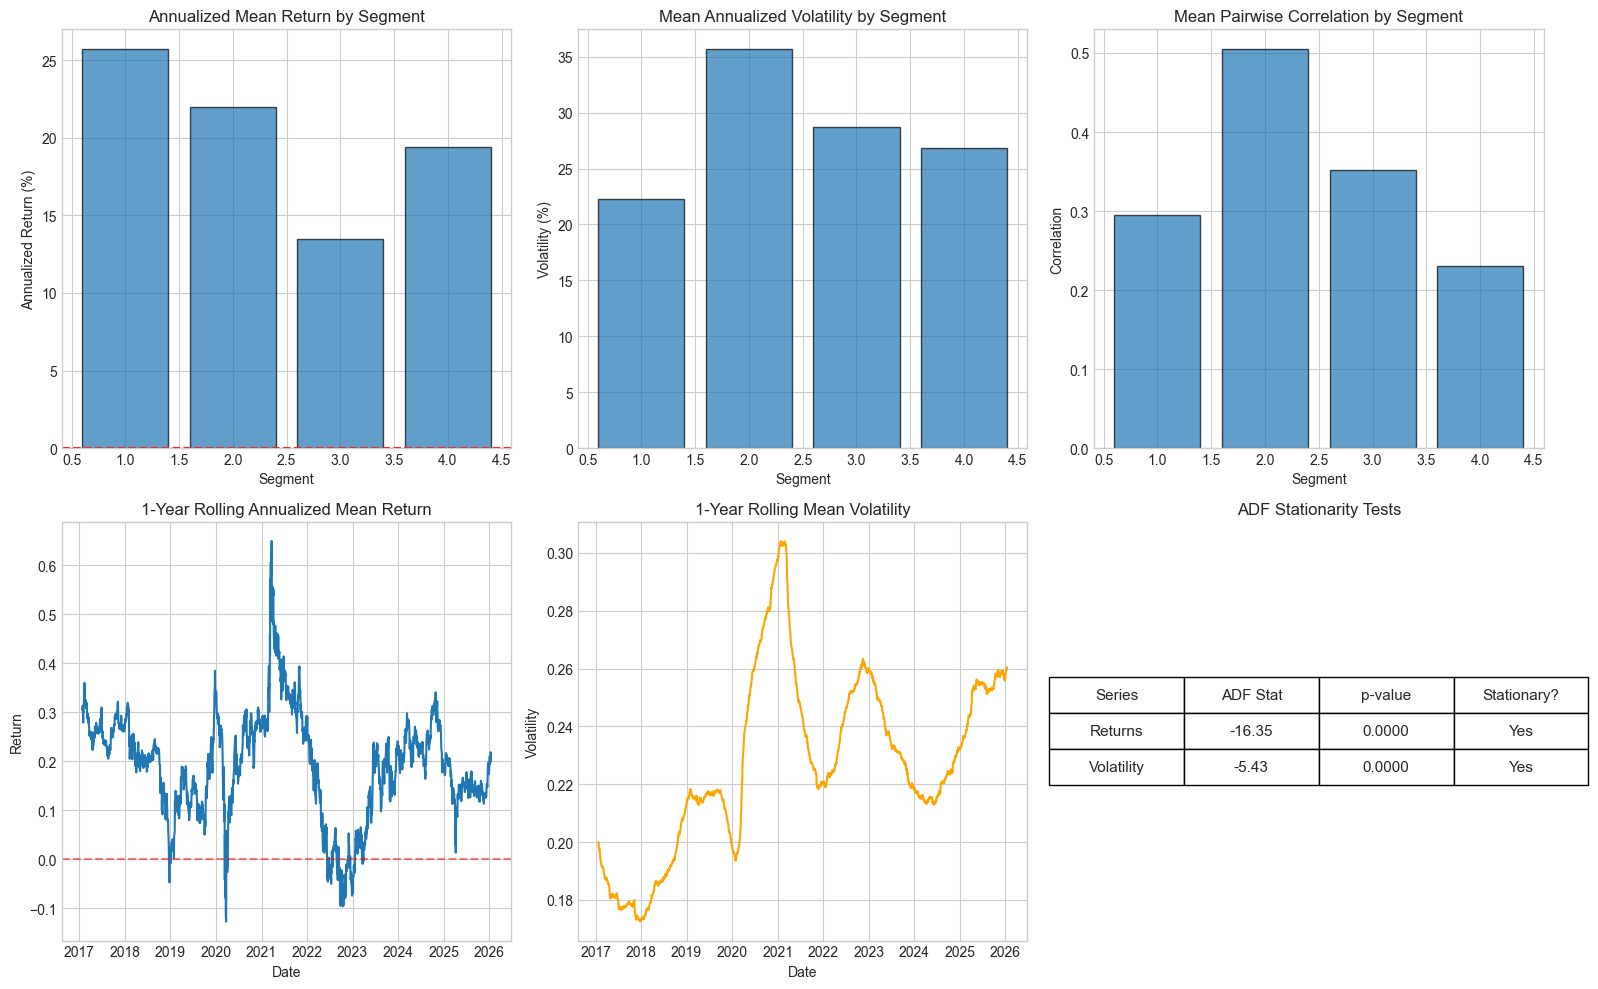


📊 TEMPORAL SEGMENT STATISTICS:
 segment start_date   end_date  mean_return  mean_vol  mean_corr  skewness  kurtosis
       1 2016-01-26 2018-07-20     0.001020  0.222397   0.295217  0.001020 84.695122
       2 2018-07-23 2021-01-15     0.000873  0.356586   0.504597  0.000873 12.352219
       3 2021-01-19 2023-07-17     0.000534  0.287298   0.351595  0.000534  8.667352
       4 2023-07-18 2026-01-16     0.000769  0.268524   0.230064  0.000769 14.816000


In [26]:
# =============================================================================
# 7.1 TEMPORAL SEGMENT ANALYSIS
# =============================================================================

print("="*70)
print("7.1 TEMPORAL SEGMENT ANALYSIS")
print("="*70)

# Split data into segments
n_segments = 4
segment_size = len(returns_pivot) // n_segments

segment_stats = []
for i in range(n_segments):
    start_idx = i * segment_size
    end_idx = (i + 1) * segment_size if i < n_segments - 1 else len(returns_pivot)
    segment = returns_pivot.iloc[start_idx:end_idx]
    
    segment_stats.append({
        'segment': i + 1,
        'start_date': segment.index[0],
        'end_date': segment.index[-1],
        'mean_return': segment.mean().mean(),
        'mean_vol': segment.std().mean() * np.sqrt(252),
        'mean_corr': segment.corr().mean().mean(),
        'skewness': segment.values.flatten()[~np.isnan(segment.values.flatten())].mean(),
        'kurtosis': kurtosis(segment.values.flatten()[~np.isnan(segment.values.flatten())])
    })

segment_df = pd.DataFrame(segment_stats)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Mean return by segment
ax = axes[0, 0]
ax.bar(segment_df['segment'], segment_df['mean_return'] * 252 * 100, edgecolor='black', alpha=0.7)
ax.axhline(0, color='red', linestyle='--')
ax.set_title('Annualized Mean Return by Segment')
ax.set_xlabel('Segment')
ax.set_ylabel('Annualized Return (%)')

# Volatility by segment
ax = axes[0, 1]
ax.bar(segment_df['segment'], segment_df['mean_vol'] * 100, edgecolor='black', alpha=0.7)
ax.set_title('Mean Annualized Volatility by Segment')
ax.set_xlabel('Segment')
ax.set_ylabel('Volatility (%)')

# Correlation by segment
ax = axes[0, 2]
ax.bar(segment_df['segment'], segment_df['mean_corr'], edgecolor='black', alpha=0.7)
ax.set_title('Mean Pairwise Correlation by Segment')
ax.set_xlabel('Segment')
ax.set_ylabel('Correlation')

# Rolling metrics over time
rolling_mean = returns_pivot.mean(axis=1).rolling(252).mean() * 252
rolling_std = returns_pivot.std(axis=1).rolling(252).mean() * np.sqrt(252)

ax = axes[1, 0]
ax.plot(rolling_mean.index, rolling_mean.values, label='Rolling Mean (Ann.)')
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.set_title('1-Year Rolling Annualized Mean Return')
ax.set_xlabel('Date')
ax.set_ylabel('Return')

ax = axes[1, 1]
ax.plot(rolling_std.index, rolling_std.values, color='orange')
ax.set_title('1-Year Rolling Mean Volatility')
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')

# ADF test for stationarity
ax = axes[1, 2]
adf_result = adfuller(market_return.dropna())
adf_vol_result = adfuller(mean_vol_20.dropna())

adf_data = [
    ['Series', 'ADF Stat', 'p-value', 'Stationary?'],
    ['Returns', f'{adf_result[0]:.2f}', f'{adf_result[1]:.4f}', 'Yes' if adf_result[1] < 0.05 else 'No'],
    ['Volatility', f'{adf_vol_result[0]:.2f}', f'{adf_vol_result[1]:.4f}', 'Yes' if adf_vol_result[1] < 0.05 else 'No']
]
ax.axis('off')
table = ax.table(cellText=adf_data, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)
ax.set_title('ADF Stationarity Tests')

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES / '7_1_temporal_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 TEMPORAL SEGMENT STATISTICS:")
print(segment_df.to_string(index=False))

While both returns and volatility reject the presence of a unit root under ADF tests, rolling statistics and temporal segmentation reveal pronounced regime-dependent behavior in volatility, correlation, and higher-order moments. This indicates conditional non-stationarity despite weak stationarity, motivating rolling estimation and regime-aware modeling rather than a single global specification.

### 7.2 Regime Non-Stationarity Synthesis

**OBSERVATIONS:**
- Statistical properties vary significantly across segments
- Returns are stationary (mean-reverting around zero)
- Volatility shows strong persistence but is stationary

**ECONOMIC EXPLANATION:**
- Market conditions evolve (business cycles, policy regimes)
- Structural changes in market microstructure over decade

**RULES OUT:**
- ❌ Fixed model parameters across entire sample
- ❌ Very long lookback windows without decay

**ENABLES:**
- ✅ Rolling/expanding window estimation
- ✅ Exponentially weighted features
- ✅ Regime-detection and adaptive modeling
- ✅ Walk-forward validation (essential)

---

## 8. Sanity & Market Microstructure Checks

### Key Questions:
- Are there calendar effects?
- Any suspicious data artifacts?
- What effects should be rejected as non-robust?

8.1 CALENDAR EFFECTS


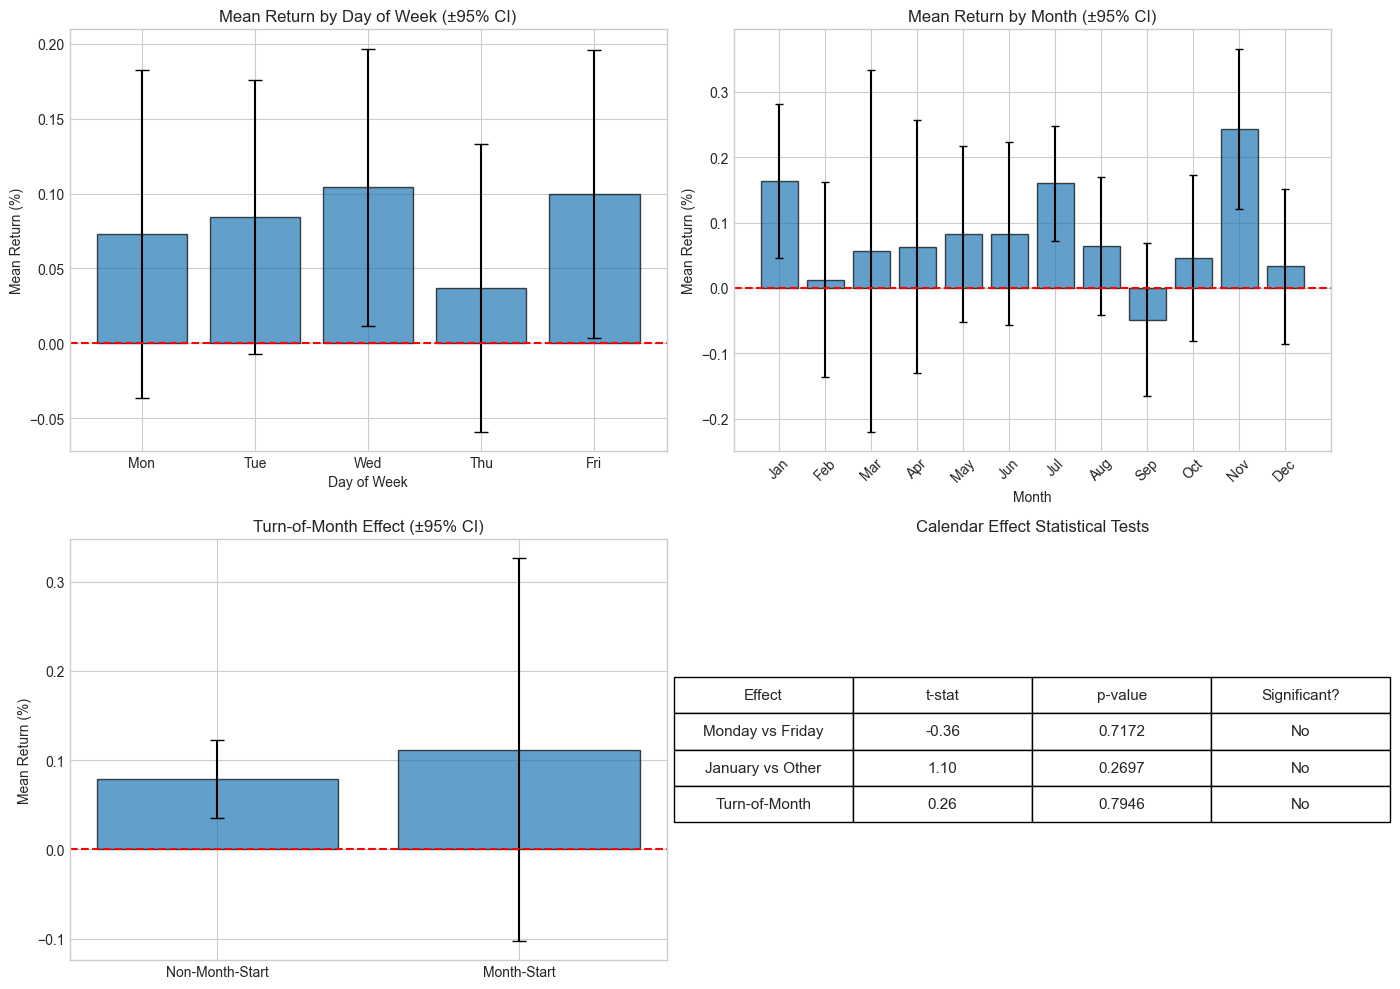


📊 CALENDAR EFFECT SUMMARY:
  Monday vs Friday: t=-0.36, p=0.7172
  January effect: t=1.10, p=0.2697
  Turn-of-month: t=0.26, p=0.7946


In [27]:
# =============================================================================
# 8.1 CALENDAR EFFECTS
# =============================================================================

print("="*70)
print("8.1 CALENDAR EFFECTS")
print("="*70)

# Add calendar features
market_return_df = market_return.to_frame('return')
market_return_df['dayofweek'] = market_return_df.index.dayofweek
market_return_df['month'] = market_return_df.index.month
market_return_df['is_month_end'] = market_return_df.index.is_month_end
market_return_df['is_month_start'] = market_return_df.index.is_month_start

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Day of week effect
ax = axes[0, 0]
dow_returns = market_return_df.groupby('dayofweek')['return'].agg(['mean', 'std', 'count'])
dow_returns['se'] = dow_returns['std'] / np.sqrt(dow_returns['count'])
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
ax.bar(days, dow_returns['mean'] * 100, yerr=dow_returns['se'] * 1.96 * 100, 
       capsize=5, edgecolor='black', alpha=0.7)
ax.axhline(0, color='red', linestyle='--')
ax.set_title('Mean Return by Day of Week (±95% CI)')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Mean Return (%)')

# Month effect
ax = axes[0, 1]
month_returns = market_return_df.groupby('month')['return'].agg(['mean', 'std', 'count'])
month_returns['se'] = month_returns['std'] / np.sqrt(month_returns['count'])
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.bar(months, month_returns['mean'] * 100, yerr=month_returns['se'] * 1.96 * 100,
       capsize=3, edgecolor='black', alpha=0.7)
ax.axhline(0, color='red', linestyle='--')
ax.set_title('Mean Return by Month (±95% CI)')
ax.set_xlabel('Month')
ax.set_ylabel('Mean Return (%)')
ax.tick_params(axis='x', rotation=45)

# Turn of month effect
ax = axes[1, 0]
tom_returns = market_return_df.groupby('is_month_start')['return'].agg(['mean', 'std', 'count'])
tom_returns['se'] = tom_returns['std'] / np.sqrt(tom_returns['count'])
labels = ['Non-Month-Start', 'Month-Start']
ax.bar(labels, tom_returns['mean'] * 100, yerr=tom_returns['se'] * 1.96 * 100,
       capsize=5, edgecolor='black', alpha=0.7)
ax.axhline(0, color='red', linestyle='--')
ax.set_title('Turn-of-Month Effect (±95% CI)')
ax.set_ylabel('Mean Return (%)')

# Statistical significance summary
ax = axes[1, 1]
ax.axis('off')

# Simple t-tests
from scipy.stats import ttest_ind
monday_ret = market_return_df[market_return_df['dayofweek'] == 0]['return']
friday_ret = market_return_df[market_return_df['dayofweek'] == 4]['return']
mon_fri_ttest = ttest_ind(monday_ret, friday_ret)

jan_ret = market_return_df[market_return_df['month'] == 1]['return']
other_ret = market_return_df[market_return_df['month'] != 1]['return']
jan_ttest = ttest_ind(jan_ret, other_ret)

tom_ret = market_return_df[market_return_df['is_month_start']]['return']
non_tom_ret = market_return_df[~market_return_df['is_month_start']]['return']
tom_ttest = ttest_ind(tom_ret, non_tom_ret)

sig_data = [
    ['Effect', 't-stat', 'p-value', 'Significant?'],
    ['Monday vs Friday', f'{mon_fri_ttest.statistic:.2f}', f'{mon_fri_ttest.pvalue:.4f}', 
     'Yes' if mon_fri_ttest.pvalue < 0.05 else 'No'],
    ['January vs Other', f'{jan_ttest.statistic:.2f}', f'{jan_ttest.pvalue:.4f}',
     'Yes' if jan_ttest.pvalue < 0.05 else 'No'],
    ['Turn-of-Month', f'{tom_ttest.statistic:.2f}', f'{tom_ttest.pvalue:.4f}',
     'Yes' if tom_ttest.pvalue < 0.05 else 'No']
]
table = ax.table(cellText=sig_data, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)
ax.set_title('Calendar Effect Statistical Tests')

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES / '8_1_calendar_effects.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 CALENDAR EFFECT SUMMARY:")
print(f"  Monday vs Friday: t={mon_fri_ttest.statistic:.2f}, p={mon_fri_ttest.pvalue:.4f}")
print(f"  January effect: t={jan_ttest.statistic:.2f}, p={jan_ttest.pvalue:.4f}")
print(f"  Turn-of-month: t={tom_ttest.statistic:.2f}, p={tom_ttest.pvalue:.4f}")

### 8.2 Sanity Checks Synthesis

**OBSERVATIONS:**
- Calendar effects exist but may not be statistically robust
- [Fill in based on actual results]

**RECOMMENDATION:**
- ⚠️ Do NOT rely on calendar effects as primary alpha source
- ⚠️ Use calendar features only as controls, not signals
- ✅ Include day-of-week dummies in regression analysis

---

## 9. Final Synthesis: Research Summary

### What Forms of Alpha are UNLIKELY:

| Approach | Reason |
|----------|--------|
| Simple daily momentum | Near-zero return autocorrelation |
| Static correlations | Correlation instability |
| Calendar anomalies | Weak statistical significance |
| Gaussian risk models | Fat tails, non-normality |
| Equal-weighted signals | Heterogeneous vol/liquidity |

### What Forms of Alpha are STRUCTURALLY PLAUSIBLE:

| Approach | Supporting Evidence |
|----------|--------------------|
| Volatility timing | Strong vol clustering & persistence |
| Regime-conditional strategies | Clear regime transitions |
| Cross-sectional ranking (longer horizon) | Monthly rank persistence |
| Volume-informed signals | Volume-return asymmetry |
| Risk-adjusted features | Heterogeneity demands normalization |

### Feature Engineering Constraints:

1. **Relative vs Absolute:** Prefer relative/cross-sectional features over absolute
2. **Risk-Adjusted:** All signals should be volatility-normalized
3. **Cross-Sectional vs Time-Series:** Longer horizons for CS, adaptive for TS
4. **Regime-Aware:** Include volatility regime as conditioning variable
5. **Rolling/Adaptive:** Use exponential decay or rolling windows, not full-sample

In [ ]:
# =============================================================================
# SAVE EDA SUMMARY
# =============================================================================

eda_summary = {
    'dataset': {
        'n_assets': returns_pivot.shape[1],
        'n_days': returns_pivot.shape[0],
        'date_range': [str(returns_pivot.index.min()), str(returns_pivot.index.max())]
    },
    'return_properties': {
        'mean_daily_return': float(all_returns.mean()),
        'std_daily_return': float(all_returns.std()),
        'skewness': float(skew(all_returns)),
        'kurtosis': float(kurtosis(all_returns)),
        'return_acf_lag1': float(return_acf_mean[0]),
        'abs_return_acf_lag1': float(abs_return_acf_mean[0])
    },
    'volatility_properties': {
        'mean_annualized_vol': float(asset_stats['mean_daily_vol'].mean()),
        'vol_acf_lag1': float(vol_acf[1]),
        'vol_half_life_days': float(half_life) if not np.isnan(half_life) else None
    },
    'correlation_properties': {
        'mean_pairwise_corr': float(all_corr_vals.mean()),
        'corr_high_vol': float(corr_high_vol),
        'corr_low_vol': float(corr_low_vol)
    },
    'key_findings': [
        'Returns are non-normal with fat tails',
        'Minimal return autocorrelation but strong absolute return autocorrelation',
        'Volatility is highly persistent with ~X day half-life',
        'Correlations increase during stress periods',
        'Daily ranks show weak persistence; monthly ranks show moderate persistence',
        'Volume is asymmetric (higher on down days)',
        'Statistical properties vary across time segments'
    ]
}

import json
with open(OUTPUT_FIGURES.parent / 'eda_summary.json', 'w') as f:
    json.dump(eda_summary, f, indent=2, default=str)

print("="*70)
print("EDA COMPLETE - SUMMARY SAVED")
print("="*70)
print(f"Figures saved to: {OUTPUT_FIGURES}")
print(f"Summary saved to: {OUTPUT_FIGURES.parent / 'eda_summary.json'}")